## Image Classification with Convolutional Neural Networks

The overall objective of this project is to develop a robust and advanced Convolutional Neural Network (CNN) architecture for image classification on the CIFAR-10 dataset, which consists of 60,000 32x32 colour images across 10 classes. The goal is to create a model that can achieve high classification accuracy on CIFAR-10 and then fine-tune the pretrained model on the CIFAR-100 dataset, which has 100 classes, to assess how well the model generalises to a broader set of classes.

The approach involves:

1. Building and training the CNN architecture specifically designed to work well on the CIFAR-10 dataset, optimising for accuracy and efficiency.
2. Transfer learning: Once the model is trained on CIFAR-10, it will be fine-tuned on CIFAR-100 to evaluate its ability to adapt to a more complex classification task.
3. Model performance evaluation: The performance of the pretrained model will be assessed across both CIFAR-10 and CIFAR-100 datasets, with a focus on comparing how well the model generalises across different levels of complexity (10 classes vs. 100 classes).

This project aims to demonstrate the flexibility of a CNN model in transfer learning, its ability to generalise from a simpler task (CIFAR-10) to a more challenging task (CIFAR-100), and assess the model's robustness and performance across these two datasets.

### Load the necessary libraries

In [ ]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [2]:
# Calculate mean and std for dataset
def compute_mean_std(dataset):
    data = np.stack([np.array(image) for image, _ in dataset], axis=0) # flattens all image data into a large array after converting image format into a numpy array for numerical operations
    mean = data.mean(axis=(0, 1, 2)) / 255.0 # compute mean across all colour channels (R, B, G). 255 refers to the original pixel intensity of images
    std = data.std(axis=(0, 1, 2)) / 255.0
    return mean, std

raw_cif10 = datasets.CIFAR10(root='./data', train=True, download=True)

mean_10, std_10 = compute_mean_std(raw_cif10)
print(f"Mean of CIFAR-10: {mean_10}, Std of CIFAR-10: {std_10}")
print(f"Classes in CIFAR-10: {raw_cif10.classes}")

raw_cif100 = datasets.CIFAR100(root='./data', train=True, download=True)

mean_100, std_100 = compute_mean_std(raw_cif100)
print(f"Mean of CIFAR-100: {mean_100}, Std of CIFAR-100: {std_100}")
print(f"Classes in CIFAR-100: {raw_cif100.classes}")

100%|██████████| 170M/170M [00:02<00:00, 69.9MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean of CIFAR-10: [0.49139968 0.48215841 0.44653091], Std of CIFAR-10: [0.24703223 0.24348513 0.26158784]
Classes in CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 169M/169M [00:03<00:00, 51.5MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Mean of CIFAR-100: [0.50707516 0.48654887 0.44091784], Std of CIFAR-100: [0.26733429 0.25643846 0.27615047]
Classes in CIFAR-100: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirre

### **Data Preprocessing**

Over the years, major advancements have been made in image classification tasks. Current neural networks that are considered state-of-the-art include transformer based models such as Vision Transformer and its variations, CNN models from the EfficientNet family (ranging from B0 to B7 -- largest and most accurate) and ResNet (ResNet-50 and 34 as strong baselines for various computer vision tasks), and hybrid architectures that combine the strengths of both transformers and CNNs. To optimally build and train a CNN model from scratch, it is key to consider best augmentation techniques from SOTA models to help improve the model's ability to generalise to unseen data and reduce the risk of overfitting. Components inspired from existing models are incorporated in the transformation pipeline as follows:
1. RandomCrop with Padding: Random cropping introduces variability in the spatial location of objects within the image, forcing the model to learn features that are invariant to translation. Padding ensures that the cropped region retains meaningful content, even near the edges of the image. This technique is widely used in SOTA frameworks such as ResNet to simulate diverse object positions and improve spatial invariance. A 32x32 pixel size and padding value of 4 are the standards used in ResNet, ensuring that cropped images retain the original size and that the cropped region would not be too close to the edges. 
2. Random Horizontal Flip: Horizontal flipping is a simple and effective way to augment data by creating mirrored versions of images. It is particularly useful for datasets where the orientation of objects is not fixed such as in the case of CIFAR-10/100. This is a standard practice in SOTA frameworks because it doubles the effective size of the dataset without introducing unrealistic distortions, improving the model's ability to generalize.
3. AutoAugment: AutoAugment contains learned augmentation strategy that automatically identifies the best combination of transformations (eg rotation, shear, color adjustments) for a given dataset. The CIFAR-10 policy has been specifically optimised for CIFAR-10, and is also applicable CIFAR-100, thus reducing the need for manual tuning of augmentation parameters and ensures optimal augmentation policies compared to RandAugment where further experimentations will be needed. This technique has been shown to significantly improve performance on benchmark datasets and is integrated into many SOTA frameworkssuch as EfficientNet. 
4. ColorJitter: Color jitter introduces variability in brightness, contrast, and saturation, simulating different lighting conditions and camera settings. This helps the model become robust to changes in color distribution, which are common in real-world scenarios. In addition, implementing it in the data augmentation pipeline aligns with SOTA frameworks such as ResNet and Wide ResNet. As auto augment includes colour based transformations as part of its learned augmentation policies that have already been optimised for CIFAR-10, the parameters are kept  relatively low at 0.2. This ensures that a mild level of variability is introdcued into the colour space without overwhelming the augmentation pipeline or conflicting with the more sophisticated transformations applied by auto augment. 
5. Normalisation: Normalisation is a fundamental step in SOTA frameworks, which standardises the pixel values of the images to have a mean and standard deviation remain consistent with the dataset's statistics, thereby stabilising training and accelerating convergence. 
6. Random Erasing: Random erasing randomly occludes parts of the image, simulating occlusions and encouraging the model to focus on less prominent features, and is particularly useful for improving robustness to partial occlusions in real-world data. In addition, this technique has been widely adopted in SOTA frameworks such as ResNet to improve performance on tasks where occlusions are common such as object classification in cluttered environments. Using a p value of 0.5 is common as it provides a good trade-off between augmentation strength and data integrity -- higher values might lead to overly aggressive augmentation while lower probabilities might not provide enough variability to improve generalisation. For the scale parameter, a range of 2-15% ensures the erased regions are neither too small nor too large, which is a widely adopted practice in SOTA framework for small scale datasets like CIFAR-10. To ensure that the occlusion is realistic, an aspect ratio of 0.8-1.5 is preferred so that the erased regions have a natural, rectangular shape.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_dataset(dataset_name, mean, std):

    # Define transformation pipeline for training (with augmentations)
    train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean.tolist(), std.tolist()),  # Normalize
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.8, 1.5), value=0)  # Random erasing experimentation to p=0.5
])

    # Define transformation pipeline for validation/test (no augmentations)
    val_test_transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean.tolist(), std.tolist()),  # Normalize
    ])

    # Load datasets with appropriate transformations
    if dataset_name == 'CIFAR10':
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
    elif dataset_name == 'CIFAR100':
        train_dataset = datasets.CIFAR100(root='./data', train=True, download=True)
        test_dataset = datasets.CIFAR100(root='./data', train=False, download=True)
    else:
        raise ValueError("Dataset name must be either 'CIFAR10' or 'CIFAR100'")

    # Split training set into train and validation subsets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size

    # Split indices into training and validation
    train_indices, val_indices = random_split(range(len(train_dataset)), [train_size, val_size])

    # Create subsets of training and validation sets to decouple the transformation
    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    val_subset = torch.utils.data.Subset(train_dataset, val_indices)

    # Apply transformations to the subsets
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_test_transform
    test_dataset.transform = val_test_transform

    # Create dataloaders
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2, drop_last=True, persistent_workers=True)
    val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2, drop_last=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, drop_last=True, persistent_workers=True)

    return train_loader, val_loader, test_loader

# Load CIFAR-10 dataset
train_loader, val_loader, test_loader = load_dataset('CIFAR10', mean_10, std_10)

# Load CIFAR-100 dataset
train_100, val_100, test_100 = load_dataset('CIFAR100', mean_100, std_100)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Multiple variations of the data augmentation pipeline have also attempted, however, this variation yielded the best result. A separate implementation with elaboration can be found below.

#### **Visualise original vs augmented images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6916624373818365e-08..0.9725490459408903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6916624373818365e-08..1.000000059160441].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6916624373818365e-08..1.000000059160441].


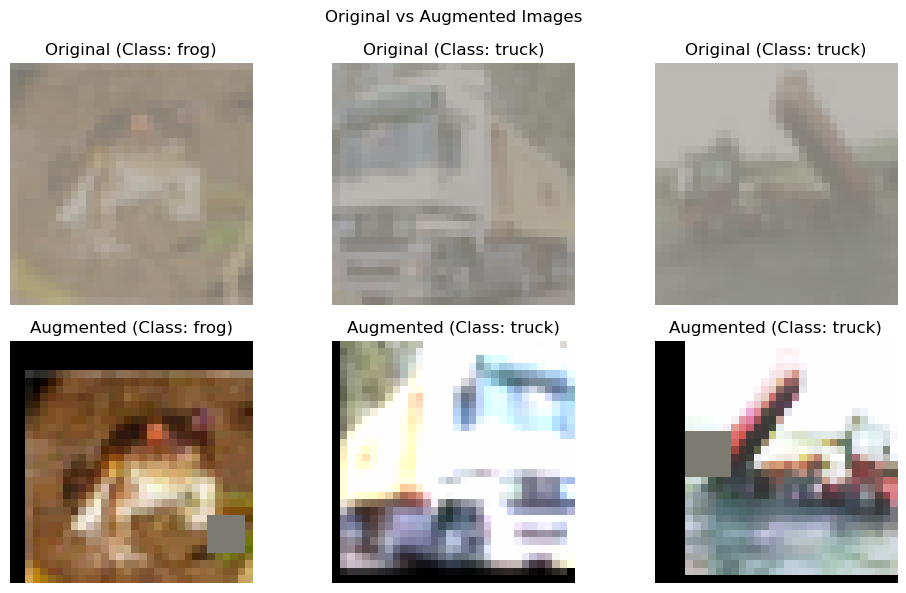

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3507692020464646e-08..1.0000000284604404].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3507692020464646e-08..1.0000000284604404].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3507692020464646e-08..0.6627451121167774].


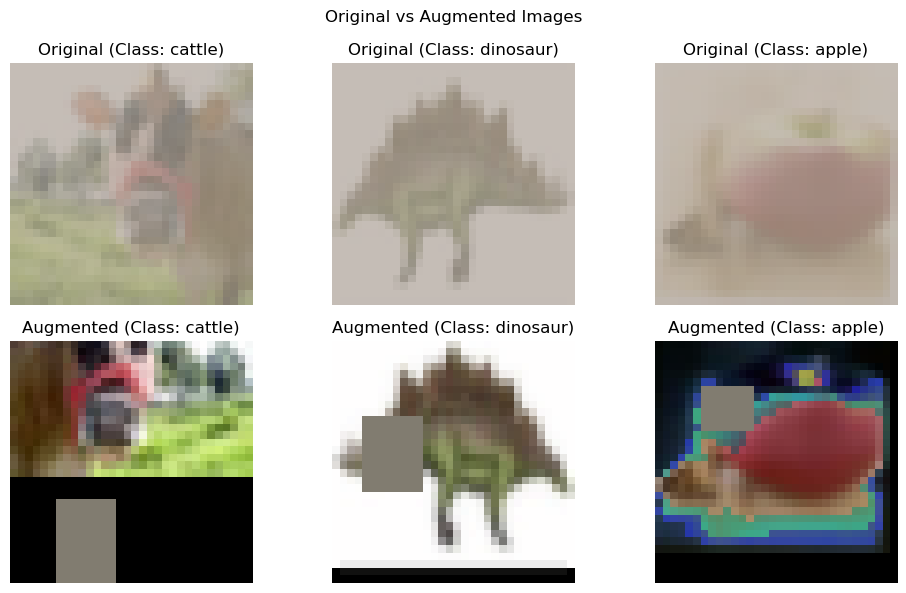

In [4]:
# Function to denormalize an image
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

# Transform pipeline for CIFAR-10
transform_cif10 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    AutoAugment(AutoAugmentPolicy.CIFAR10),  # Use CIFAR-10 specific policy
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean_10.tolist(), std_10.tolist()),  # Normalize
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.8, 1.5), value=0)  # Random erasing
])

# Transform pipeline for CIFAR-100
transform_cif100 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    AutoAugment(AutoAugmentPolicy.CIFAR10),  # Use CIFAR-10 specific policy
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean_100.tolist(), std_100.tolist()),  # Normalize
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.8, 1.5), value=0)  # Random erasing
])

# Define function to visualize both original and augmented images
def visualize_images(dataset, mean, std, transform):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    fig.suptitle('Original vs Augmented Images')

    for i in range(3):
        original_image, label_index = dataset[i]  # Get label index

        # Get class name
        class_name = dataset.classes[label_index]

        # Convert original image to tensor if it's a PIL image
        if isinstance(original_image, Image.Image):
            original_image = transforms.ToTensor()(original_image)

        original_image_pil = transforms.ToPILImage()(original_image)
        augmented_image = transform(original_image_pil)

        # Denormalize
        original_image_denorm = denormalize(original_image, mean, std)
        augmented_image_denorm = denormalize(augmented_image, mean, std)

        # Convert to numpy for visualization
        original_image_denorm = original_image_denorm.permute(1, 2, 0).numpy()
        augmented_image_denorm = augmented_image_denorm.permute(1, 2, 0).numpy()

        # Plot original image
        axes[0, i].imshow(original_image_denorm)
        axes[0, i].set_title(f'Original (Class: {class_name})')
        axes[0, i].axis('off')

        # Plot augmented image
        axes[1, i].imshow(augmented_image_denorm)
        axes[1, i].set_title(f'Augmented (Class: {class_name})')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize images for CIFAR-10
visualize_images(raw_cif10, mean_10, std_10, transform_cif10)

# Visualize images for CIFAR-100
visualize_images(raw_cif100, mean_100, std_100, transform_cif100)

### **CNN Architecture for image classification**

To develop the CNN architecture for the classification task, design principles from state-of-the-art (SOTA) frameworks such as ResNet, EfficientNet, and Vision Transformers (ViTs) are incorporated. These principles ensure the model is both effective and efficient, while also being capable of generalizing well to diverse datasets like CIFAR-10 and CIFAR-100.


1. **Stem block:** The stem block is included as the first layer in the CNN, responsible for initial feature extraction from the input image. While ResNet traditionally uses a ```7x7``` convolution in its stem, this architecture employs a ```3x3``` kernel to ensure computational efficiency while still capturing meaningful low-level features like edges and textures. This design choice aligns with EfficientNet, which also uses smaller kernels in the stem block to reduce computational cost without sacrificing feature extraction capability.
2. **Residual stages:** The residual stages are inspired by ResNet's residual blocks, which use skip connections to enable the training of very deep networks. In this architecture, each stage consists of two convolutional layers with batch normalization and GELU activation. This design allows gradients to flow through multiple layers, mitigating the vanishing gradient problem and enabling stable training. Each stage progressively increases the number of filters (```64 → 128 → 256 → 512```) and reduces spatial dimensions using strides of 2 in layer2 and layer3. This hierarchical structure allows the network to capture increasingly complex features (e.g., shapes, objects) at different scales, a principle also seen in EfficientNet and ResNet.
3. **Batch normalisation:** Batch normalization is applied after every convolutional layer to normalize the activations, reducing internal covariate shift and enabling faster, more stable training. It also acts as a mild regularizer, reducing the need for other regularization techniques like dropout in the early layers. This approach is a core component of ResNet and is widely adopted in SOTA frameworks, including EfficientNet and DenseNet.
4. **GELU activation:** While ReLU is traditionally used in ResNet, GELU (Gaussian Error Linear Unit) has been shown to outperform ReLU in more recent architectures like Transformers and EfficientNet. Unlike ReLU, GELU is a smooth, differentiable activation function that provides better gradient flow and avoids the "dying ReLU" problem. Its inclusion in this architecture reflects the shift toward more advanced activation functions in modern deep learning models.
5. **Adaptive average pooling:** Adaptive average pooling is used to summarize the spatial dimensions of the feature maps into a single vector per channel, making the network invariant to input size. This is particularly useful for transfer learning, as the model trained on CIFAR-10 can be fine-tuned on CIFAR-100 without requiring architectural changes. This technique is commonly used in ResNet and EfficientNet and is a key component of many SOTA frameworks.
6. **Layer normalisation:** Layer normalization is applied before the final fully connected layer to stabilize training and improve convergence. While it is more commonly used in Transformers, it is gaining popularity in modern CNN architectures for its ability to reduce overfitting and improve stability. Its inclusion in this architecture reflects the growing influence of Transformer-based techniques in computer vision.
7. **Dropout:** Dropout is used in the final layers to regularize the network and prevent overfitting. By randomly deactivating neurons during training, dropout forces the network to rely on multiple features rather than a few dominant ones. This technique is often used in the final layers of ResNet and EfficientNet, as well as in Transformers, to improve generalization.


These choices ensure that the architecture is modern, efficient, and aligned with SOTA frameworks, making it well-suited for tasks like image classification on datasets such as CIFAR-10 and CIFAR-100.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU()
        )

        # Residual stages
        self.layer1 = self._make_layer(64, 128, stride=1)
        self.layer2 = self._make_layer(128, 256, stride=2)
        self.layer3 = self._make_layer(256, 512, stride=2)

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Aside from the above architecture, 3 other architectures were also experimented. Further elaborations on each variation can be found below. However, this implementation gave the best results, thus chosen for the classification task.

### **Train model on CIFAR-10**

In addition to the CNN architecture, the training process incorporates several key components to ensure efficient and effective model training. These components are designed to prevent overfitting, stabilize training, and improve generalization, aligning with SOTA practices in deep learning. 
1. **Early stopping:** To prevent the model from overfitting to the training data, early stopping is employed. This technique monitors the validation accuracy during training and halts the process once the model's performance on the validation set stops improving. A patience value of 5 is used, meaning training will stop if the validation accuracy does not improve for 5 consecutive epochs. This value strikes a balance between giving the model enough time to improve and avoiding unnecessary computation. Additionally, a small delta of 0.001 is set as the minimum improvement required to reset the patience counter, ensuring that only meaningful improvements are considered. Early stopping not only prevents overfitting but also saves computational resources and ensures the model generalizes well to unseen data. This technique is widely used in SOTA frameworks like ResNet, EfficientNet, and Transformers, particularly when training large models on large datasets.
2. **Optimiser:** Stochastic Gradient Descent (SGD) with momentum and Nesterov acceleration is chosen due to its effectiveness and alignment with SOTA practices. The learning rate is set to 0.1, a relatively high initial value that allows for faster convergence, especially when combined with a learning rate scheduler. Momentum, set to 0.9, accelerates SGD by accumulating a velocity vector in the direction of consistent gradient updates, smoothing the optimization process and helping the model escape local minima. To further enhance performance, Nesterov acceleration is enabled, which improves upon standard momentum by looking ahead in the direction of the gradient, leading to faster convergence and better results. Additionally, weight decay (L2 regularization) is applied with a value of 5e-4 to penalize large weights and prevent overfitting. This combination of techniques is a popular choice in SOTA frameworks like ResNet, EfficientNet, and Vision Transformers (ViTs), particularly when paired with learning rate schedulers and warmup strategies.
3. **Loss function:** CIFAR10 and 100 both comprise of multiple classes, and CrossEntropyLoss is the standard choice for such tasks because it directly optimizes the model to predict the correct class probabilities, and avoids the vanishing gradient problem that can occur with other loss functions like Mean Squared Error (MSE) in classification tasks. To further improve the model's generalization and robustness, label smoothing is applied to CrossEntropyLoss to prevent the model from becoming overconfident in its predictions. This approach iw widely used in SOTA frameworks for classification tasks.
4. **Learning rate scheduler:** To further stabilize training and improve convergence, a learning rate scheduler combining warmup and cosine annealing is employed. During the first 5 epochs, the learning rate is gradually increased from 0 to the base learning rate (0.1) in a process known as the warmup phase. This stabilizes training at the beginning, particularly when using high initial learning rates or large batch sizes. After the warmup phase, the cosine annealing scheduler takes over, reducing the learning rate in a smooth, cosine-shaped curve over the remaining epochs. The minimum learning rate is set to 1e-5 to ensure the model continues fine-tuning without the learning rate dropping to zero. This combination of warmup and cosine annealing is widely used in SOTA frameworks like ResNet, EfficientNet, and Transformers, as it provides a smooth and gradual reduction in the learning rate, helping the model converge to a better minimum.

Epoch 1, Train Loss: 2.3708, Train Acc: 0.2676
Validation Loss: 1.9057, Validation Acc: 0.3368
New best model saved with validation accuracy: 0.3368
Validation accuracy improved to 0.3368


Epoch 2, Train Loss: 1.7503, Train Acc: 0.4209
Validation Loss: 1.5745, Validation Acc: 0.5022
New best model saved with validation accuracy: 0.5022
Validation accuracy improved to 0.5022


Validation accuracy did not improve. Patience: 1/5


Epoch 4, Train Loss: 1.3584, Train Acc: 0.6139
Validation Loss: 1.2990, Validation Acc: 0.6489
New best model saved with validation accuracy: 0.6489
Validation accuracy improved to 0.6489


Validation accuracy did not improve. Patience: 1/5


Epoch 6, Train Loss: 1.1713, Train Acc: 0.7082
Validation Loss: 1.1836, Validation Acc: 0.7047
New best model saved with validation accuracy: 0.7047
Validation accuracy improved to 0.7047


Epoch 7, Train Loss: 1.1059, Train Acc: 0.7406
Validation Loss: 1.1086, Validation Acc: 0.7409
New best model saved with validation accuracy: 0.7409
Validation accuracy improved to 0.7409


Validation accuracy did not improve. Patience: 1/5


Epoch 9, Train Loss: 1.0051, Train Acc: 0.7883
Validation Loss: 0.9870, Validation Acc: 0.7944
New best model saved with validation accuracy: 0.7944
Validation accuracy improved to 0.7944


Validation accuracy did not improve. Patience: 1/5


Epoch 11, Train Loss: 0.9318, Train Acc: 0.8242
Validation Loss: 0.9781, Validation Acc: 0.8002
New best model saved with validation accuracy: 0.8002
Validation accuracy improved to 0.8002


Validation accuracy did not improve. Patience: 1/5


Epoch 13, Train Loss: 0.8763, Train Acc: 0.8507
Validation Loss: 0.9409, Validation Acc: 0.8172
New best model saved with validation accuracy: 0.8172
Validation accuracy improved to 0.8172


Epoch 14, Train Loss: 0.8467, Train Acc: 0.8639
Validation Loss: 0.9295, Validation Acc: 0.8245
New best model saved with validation accuracy: 0.8245
Validation accuracy improved to 0.8245


Validation accuracy did not improve. Patience: 1/5


Epoch 16, Train Loss: 0.8019, Train Acc: 0.8856
Validation Loss: 0.8932, Validation Acc: 0.8425
New best model saved with validation accuracy: 0.8425
Validation accuracy improved to 0.8425


Validation accuracy did not improve. Patience: 1/5


Validation accuracy did not improve. Patience: 2/5


Validation accuracy did not improve. Patience: 3/5


Validation accuracy did not improve. Patience: 4/5


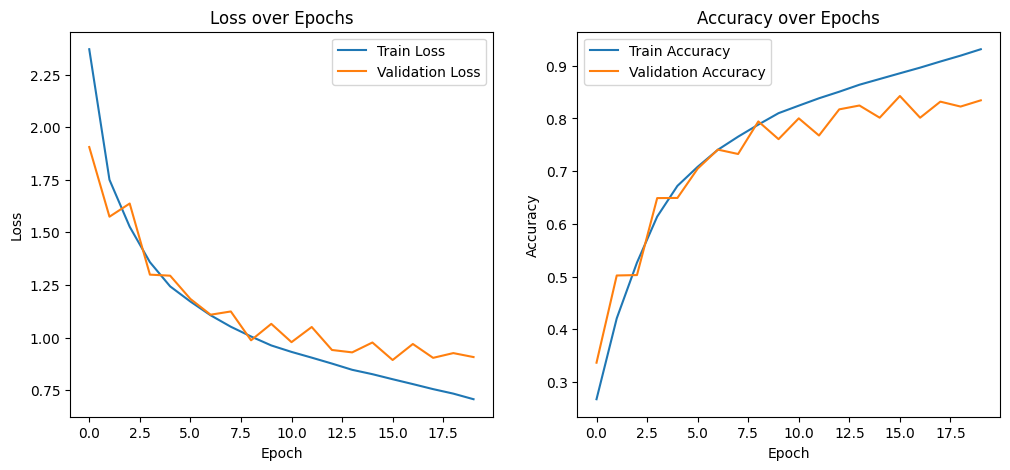

In [ ]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, verbose=True, delta=0.001):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_val_accuracy = 0.0
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_accuracy):
        if val_accuracy > self.best_val_accuracy + self.delta:
            self.best_val_accuracy = val_accuracy
            self.counter = 0
            if self.verbose:
                print(f"Validation accuracy improved to {val_accuracy:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Validation accuracy did not improve. Patience: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# Training Loop with Early Stopping
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, save_path='best_model.pth'):
    model.train()
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(epochs):
        running_loss = 0.0
        running_correct, total_samples = 0, 0

        # Training loop
        model.train()
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for image, labels in train_loop:
            image, labels = image.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * image.size(0)
            _, pred = torch.max(outputs, 1)
            running_correct += (pred == labels).sum().item()
            total_samples += labels.size(0)

            train_loop.set_postfix(loss=loss.item(), acc=(running_correct / total_samples))

        epoch_loss = running_loss / total_samples
        epoch_acc = running_correct / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for val_images, val_labels in val_loop:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss += criterion(val_outputs, val_labels).item() * val_images.size(0)
                _, val_pred = torch.max(val_outputs, 1)
                val_correct += (val_pred == val_labels).sum().item()
                val_total += val_labels.size(0)

                val_loop.set_postfix(loss=val_loss / val_total, acc=(val_correct / val_total))

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save model if validation accuracy improves
        if val_acc > early_stopping.best_val_accuracy + early_stopping.delta:
            print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
            print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

            torch.save(model.state_dict(), save_path)
            print(f'New best model saved with validation accuracy: {val_acc:.4f}')

        # Update the scheduler
        scheduler.step()

        # Early stopping
        early_stopping(val_acc)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

# Plot training and validation loss
def plot_progress(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()

# Initialize the model for CIFAR-10, loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for regularization

# SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)

# Learning rate scheduler with warmup and cosine annealing
def warmup_lr_scheduler(optimizer, warmup_epochs, base_lr):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        return 1.0
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

epochs = 20  # Increased epochs for better convergence

scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        warmup_lr_scheduler(optimizer, warmup_epochs=5, base_lr=0.1),  # Warmup for 5 epochs
        torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs - 5, eta_min=1e-5)  # Cosine annealing
    ],
    milestones=[5]
)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=epochs, save_path='cifar10_model.pth'
)

# Plot training progress
plot_progress(train_losses, val_losses, train_accuracies, val_accuracies)

### **Transfer learning on CIFAR-100**

Using the pre-trained model on CIFAR-100, this is an instance of transfer learning. Since CIFAR-10 and CIFAR-100 are both image classification datasets with similar characteristics, transfer learning is this scenario can be highly effective. To ensure that the model correctly classifies the new dataset, the final classification layer is modified to output 100 classes instead of 10. In addition, as the model has already learned useful features from CIFAR-10 training, the fine-tuning process only needs to adapt these features to the new task. Thus, a lower learning rate and shorter warmup phase are used instead. Besides, using a high learning rate or a long warmup phase during fine-tuning could overwrite these useful weights, leading to a loss of valuable knowledge. This practices ensures that the fine-tuning process is more efficient, stable, and effective, aligning with SOTA practices in deep learning.

Epoch 1/20 [Train]:   1%|          | 2/312 [00:00<00:18, 16.62it/s, acc=0.0234, loss=4.82]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1, Train Loss: 3.2126, Train Acc: 0.2842
Validation Loss: 2.7175, Validation Acc: 0.4070
New best model saved with validation accuracy: 0.4070
Validation accuracy improved to 0.4070


Epoch 2, Train Loss: 2.6016, Train Acc: 0.4488
Validation Loss: 2.4848, Validation Acc: 0.4786
New best model saved with validation accuracy: 0.4786
Validation accuracy improved to 0.4786


Epoch 3, Train Loss: 2.3868, Train Acc: 0.5111
Validation Loss: 2.3704, Validation Acc: 0.5158
New best model saved with validation accuracy: 0.5158
Validation accuracy improved to 0.5158


Epoch 4, Train Loss: 2.2328, Train Acc: 0.5614
Validation Loss: 2.2572, Validation Acc: 0.5483
New best model saved with validation accuracy: 0.5483
Validation accuracy improved to 0.5483


Epoch 5, Train Loss: 2.1182, Train Acc: 0.6008
Validation Loss: 2.2042, Validation Acc: 0.5656
New best model saved with validation accuracy: 0.5656
Validation accuracy improved to 0.5656


Epoch 6, Train Loss: 2.0092, Train Acc: 0.6361
Validation Loss: 2.2047, Validation Acc: 0.5674
New best model saved with validation accuracy: 0.5674
Validation accuracy improved to 0.5674


Epoch 7, Train Loss: 1.9137, Train Acc: 0.6704
Validation Loss: 2.1844, Validation Acc: 0.5763
New best model saved with validation accuracy: 0.5763
Validation accuracy improved to 0.5763


Epoch 8, Train Loss: 1.8343, Train Acc: 0.6965
Validation Loss: 2.1265, Validation Acc: 0.5907
New best model saved with validation accuracy: 0.5907
Validation accuracy improved to 0.5907


Epoch 9, Train Loss: 1.7467, Train Acc: 0.7280
Validation Loss: 2.1028, Validation Acc: 0.6013
New best model saved with validation accuracy: 0.6013
Validation accuracy improved to 0.6013


Validation accuracy did not improve. Patience: 1/5


Validation accuracy did not improve. Patience: 2/5


Validation accuracy did not improve. Patience: 3/5


Validation accuracy did not improve. Patience: 4/5


Validation accuracy did not improve. Patience: 5/5
Early stopping triggered at epoch 14


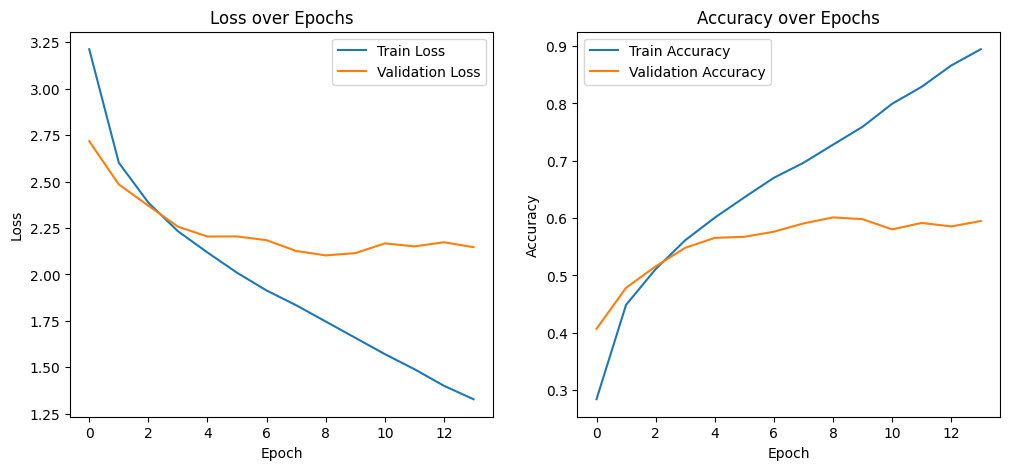

In [ ]:
# Load pre-trained model
model_100 = CNN(num_classes=10).to(device)  # Initialize with 10 classes (CIFAR-10 architecture)
model_100.load_state_dict(torch.load('cifar10_model.pth'))  # Load CIFAR-10 weights

# Replace the classifier for CIFAR-100
model_100.fc = nn.Sequential(
    nn.LayerNorm(512),
    nn.Dropout(0.3),
    nn.Linear(512, 100)  # 100 classes for CIFAR-100
).to(device)  # Move the new classifier to the correct device

# Unfreeze all layers
for param in model_100.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for regularization
optimizer_100 = torch.optim.SGD(model_100.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, nesterov=True)

# Define the learning rate scheduler
epochs = 20  # Total epochs for fine-tuning
scheduler_100 = torch.optim.lr_scheduler.SequentialLR(
    optimizer_100,
    schedulers=[
        warmup_lr_scheduler(optimizer_100, warmup_epochs=3, base_lr=0.01),  # Warmup for 3 epochs
        torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_100, T_max=epochs - 3, eta_min=1e-5)  # Cosine annealing
    ],
    milestones=[3]  # Switch to cosine annealing after warmup
)

# Call the training function
train_losses_100, train_accuracies_100, val_losses_100, val_accuracies_100 = train(
    model_100, train_100, val_100, criterion, optimizer_100, scheduler_100, epochs=20, save_path='cifar100_model.pth'
)

plot_progress(train_losses_100, val_losses_100, train_accuracies_100, val_accuracies_100)

When comparing the performance of the validation set across the two datasets, it is evident that the validation accuracy on CIFAR-100 is lower than on CIFAR-10. This discrepancy can be attributed to several key factors related to the inherent differences between the datasets, the complexity of the classification tasks, and the challenges of adapting a model trained on CIFAR-10 to CIFAR-100.
1.  **Increased Number of Classes:** CIFAR-10 consists of 10 classes, while CIFAR-100 has 100 classes. The tenfold increase in the number of classes significantly raises the complexity of the classification task. The model must now distinguish between many more categories, which requires a more sophisticated understanding of the data. This increased complexity naturally leads to a lower validation accuracy on CIFAR-100 compared to CIFAR-10.
2. **Fine-Grained Classification:** CIFAR-100 introduces fine-grained categories that are visually similar, making the classification task more challenging. For example, CIFAR-10 has a single broad category like "bird," whereas CIFAR-100 includes multiple specific bird species such as "sparrow", "parrot" and "penguin". This fine-grained nature of CIFAR-100 demands a higher level of discriminative power from the model, which is harder to achieve compared to the broader categories in CIFAR-10.
3. **Fewer Training Examples per Class:** Both CIFAR-10 and CIFAR-100 contain 50,000 training images, but the distribution of these images across classes differs significantly. With fewer training examples per class, the model struggles to learn robust and generalizable features for each category. This data scarcity also increases the risk of overfitting, as evidenced by the larger gap between training and validation accuracy on CIFAR-100. Effective regularization techniques (e.g., dropout, weight decay) are essential to mitigate this issue, but even with regularization, the model may still achieve lower validation accuracy due to the limited data availability.
4. **Model Capacity and Architecture:** The model may lack the necessary depth or width to capture the fine-grained features required for CIFAR-100. The number of filters or layers optimized for CIFAR-10 may not scale well to the more challenging CIFAR-100 task, leading to suboptimal performance. As a result, the model may struggle to achieve high validation accuracy on CIFAR-100, even after fine-tuning.

### **Model testing**

Metrics for CIFAR-10 dataset
Test Loss: 0.8987, Test Accuracy: 83.5938%
Test Precision: 0.8371, Test Recall: 0.8359, Test F1 Score: 0.8346


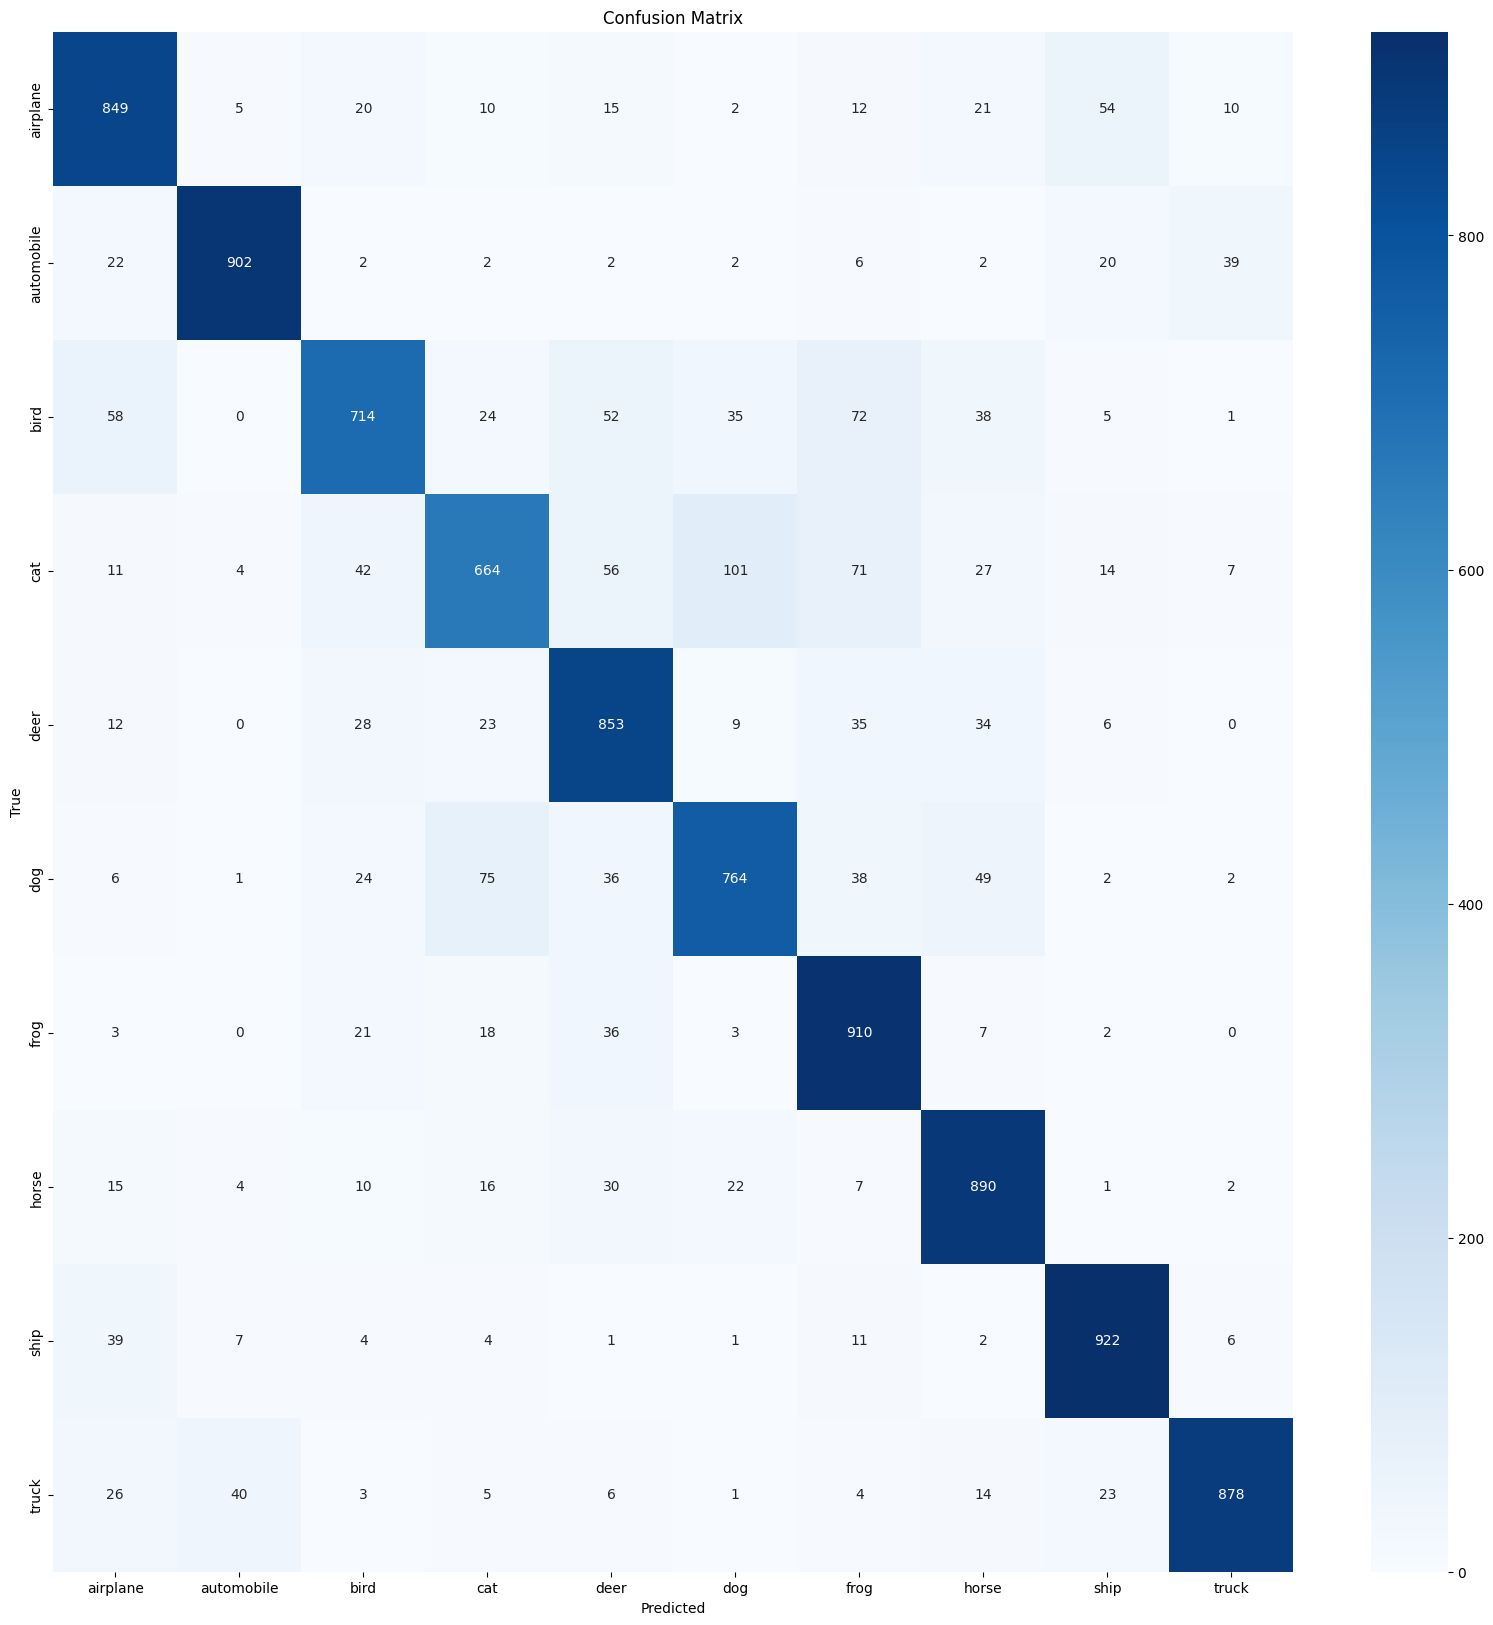

Metrics for CIFAR-100 dataset
Test Loss: 2.1324, Test Accuracy: 60.3966%
Test Precision: 0.6155, Test Recall: 0.6039, Test F1 Score: 0.6047


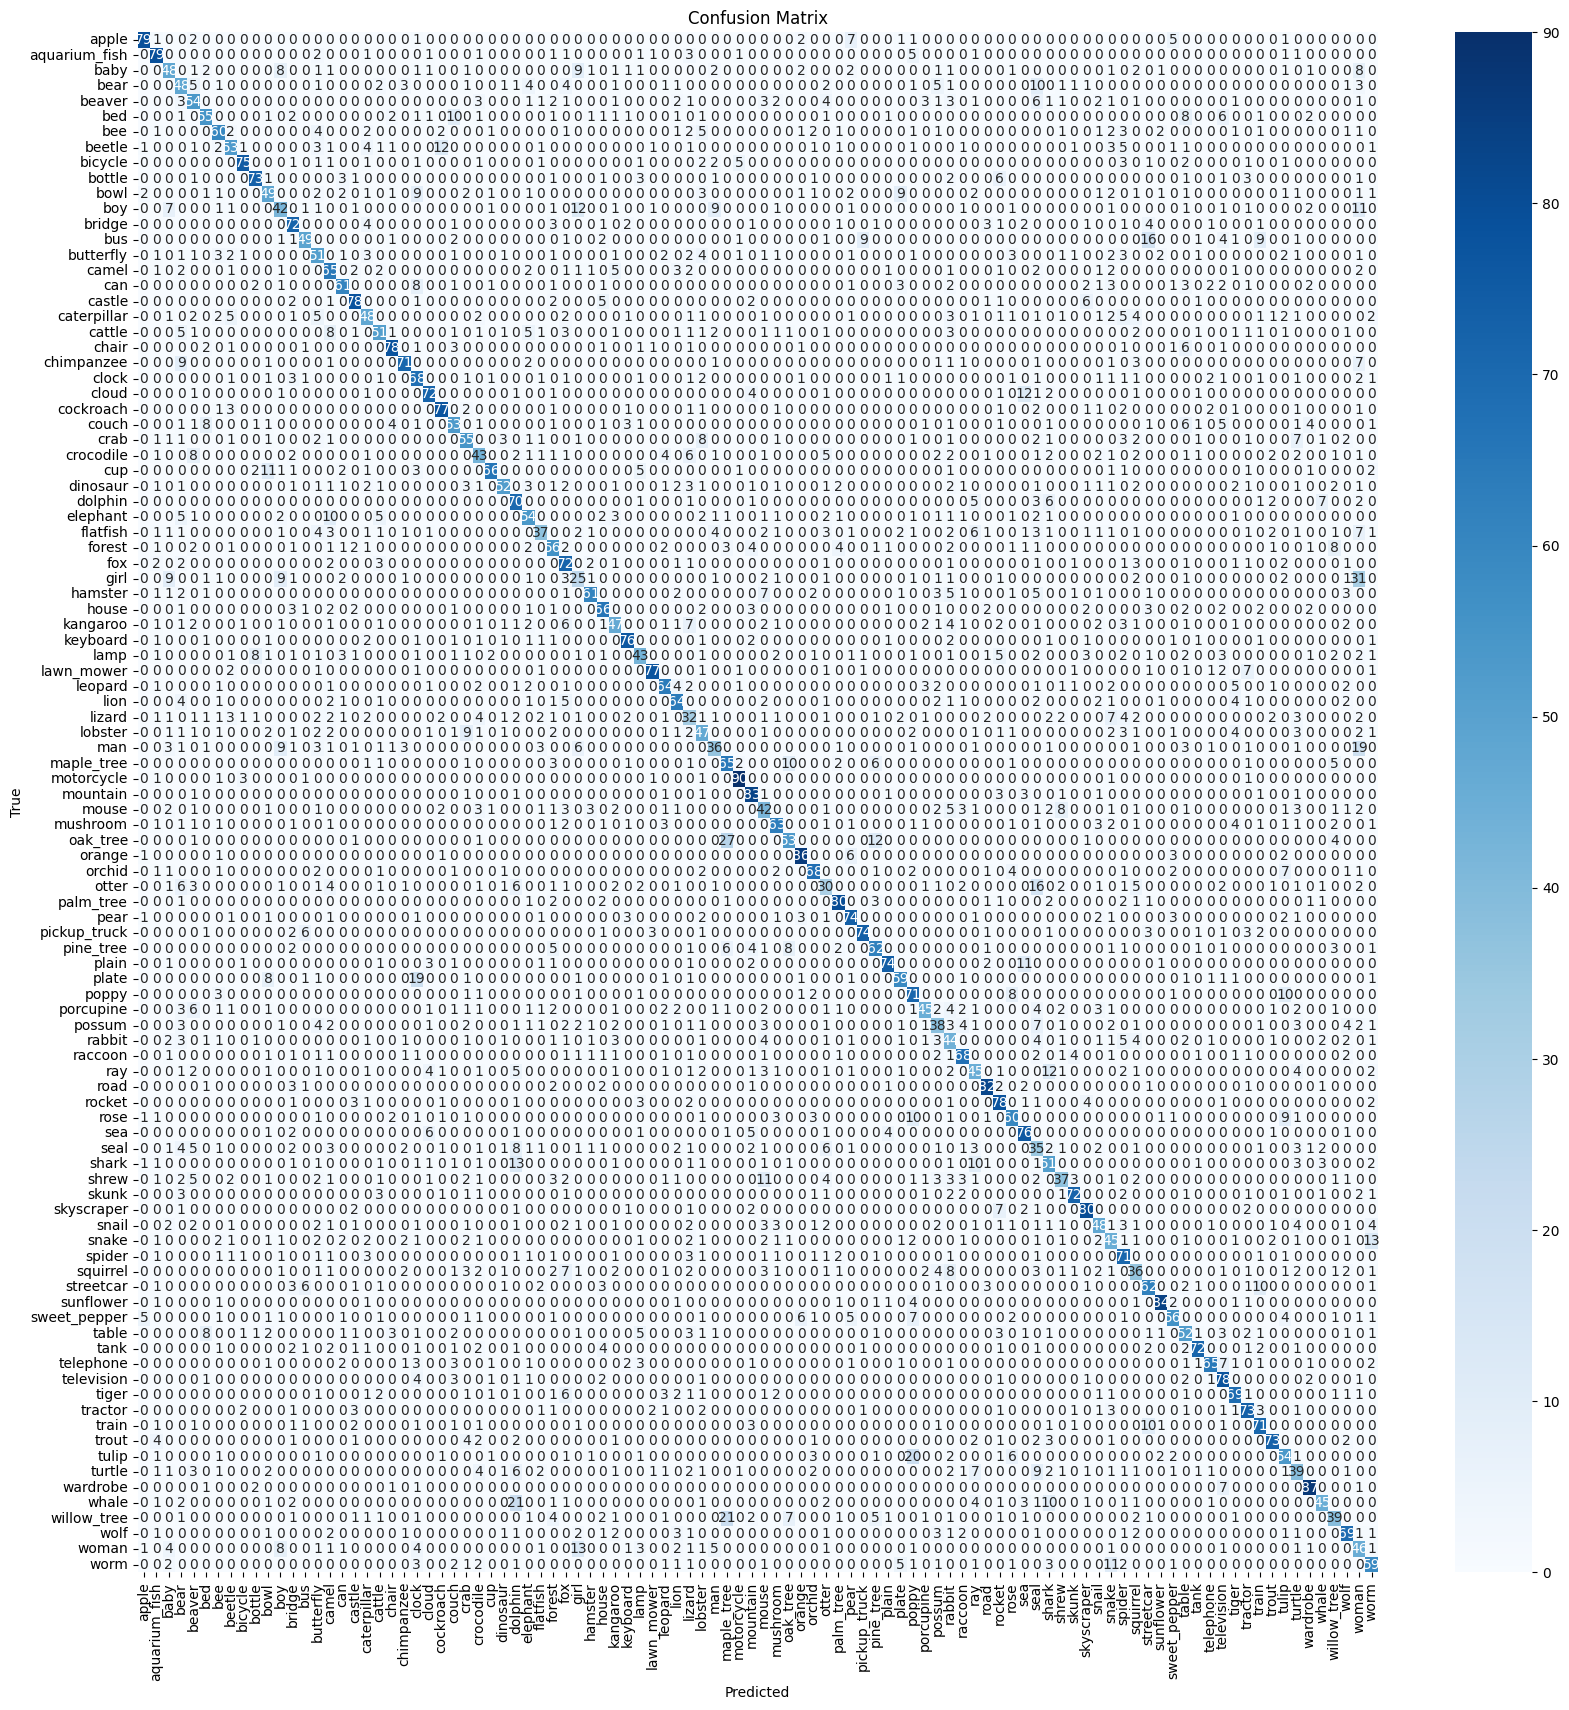

In [ ]:
def test(model, test_loader, criterion, data='CIFAR-10'):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct, test_total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for test_images, test_labels in test_loader:
            # Move data to the same device as the model
            test_images, test_labels = test_images.to(device), test_labels.to(device)

            # Forward pass
            test_outputs = model(test_images)

            # Calculate loss
            loss = criterion(test_outputs, test_labels)
            test_loss += loss.item() * test_images.size(0)

            # Calculate accuracy
            _, test_preds = torch.max(test_outputs, 1)
            test_correct += (test_preds == test_labels).sum().item()
            test_total += test_labels.size(0)

            # Store predictions and labels for additional metrics
            all_preds.extend(test_preds.cpu().numpy())
            all_labels.extend(test_labels.cpu().numpy())

    # Calculate average loss and accuracy
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total

    # Calculate precision, recall, and F1 score
    test_precision = precision_score(all_labels, all_preds, average='macro')
    test_recall = recall_score(all_labels, all_preds, average='macro')
    test_f1 = f1_score(all_labels, all_preds, average='macro')

    # Print results
    print(f'Metrics for {data} dataset')
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.4f}%")
    print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return test_loss, test_acc, test_precision, test_recall, test_f1

# Call function for CIFAR-10
test_loss, test_acc, test_precision, test_recall, test_f1 = test(model, test_loader, criterion)

# Call function for CIFAR-100
test_loss_100, test_acc_100, test_precision_100, test_recall_100, test_f1_100 = test(model_100, test_100, criterion, data='CIFAR-100')

A strong diagonal dominance is observed when the model was tested on CIFAR-10, indicating that it achieved high accuracy in classifying each of the ten distinct object categories.  In essence, the model made very few errors, demonstrating a robust ability to differentiate between classes like airplanes, cats, and dogs.  This success suggests that the CNN effectively learned the discriminative features necessary for accurate classification within the CIFAR-10 domain. 

However, the real challenge arose when the knowledge gained from CIFAR-10 was leveraged through transfer learning on the more complex CIFAR-100 dataset.  The second confusion matrix paints a starkly different picture.  While the diagonal is still visible, it is significantly less pronounced, revealing a substantial drop in overall accuracy.  This indicates that the model struggled to generalize its learned representations to the finer-grained classification task of CIFAR-100, which contains 100 object classes, many of which share subtle visual similarities. The increased confusion between classes is a key observation.  Instead of clear, distinct predictions, there is a wider spread of errors across the off-diagonal elements.  This suggests that the model is frequently misclassifying images, confusing, for example, different types of birds or vehicles. The complexity of CIFAR-100, with its more nuanced categories, likely contributed to this confusion.  The features learned from CIFAR-10, while effective for distinguishing broad categories, may not be sufficiently discriminative for the finer distinctions required by CIFAR-100. Furthermore, analyzing specific class performance within the CIFAR-100 results reveals areas of particular weakness.  Certain classes exhibit low diagonal values and high off-diagonal values, indicating consistent misclassification.  This suggests that these classes share visual characteristics with other categories, making them difficult for the model to differentiate.  For instance, it is observed that the model frequently confuses different types of trees or flowers, highlighting the challenge of distinguishing subtle variations within those categories.

The significant performance drop underscores the inherent difficulty of transferring knowledge from a simpler, 10-class problem to a more complex, 100-class problem.  While transfer learning offers the potential to leverage pre-trained models and reduce training time, it is not guaranteed.  The success of transfer learning hinges on the similarity between the source and target datasets, and the degree to which the learned features are relevant to the new task.  In this case, the shift from CIFAR-10 to CIFAR-100 likely introduced a substantial domain gap, necessitating further adaptation or refinement of the model.

### **Analysis of misclassified images**

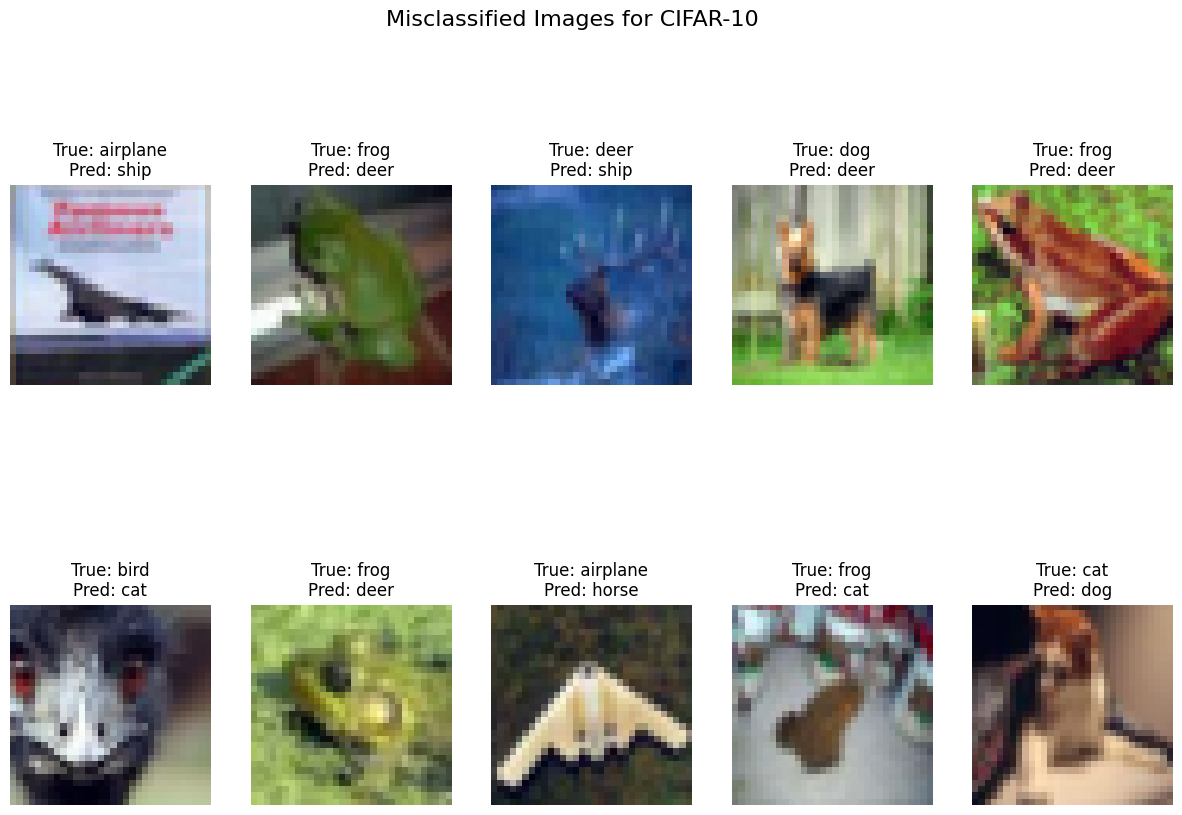

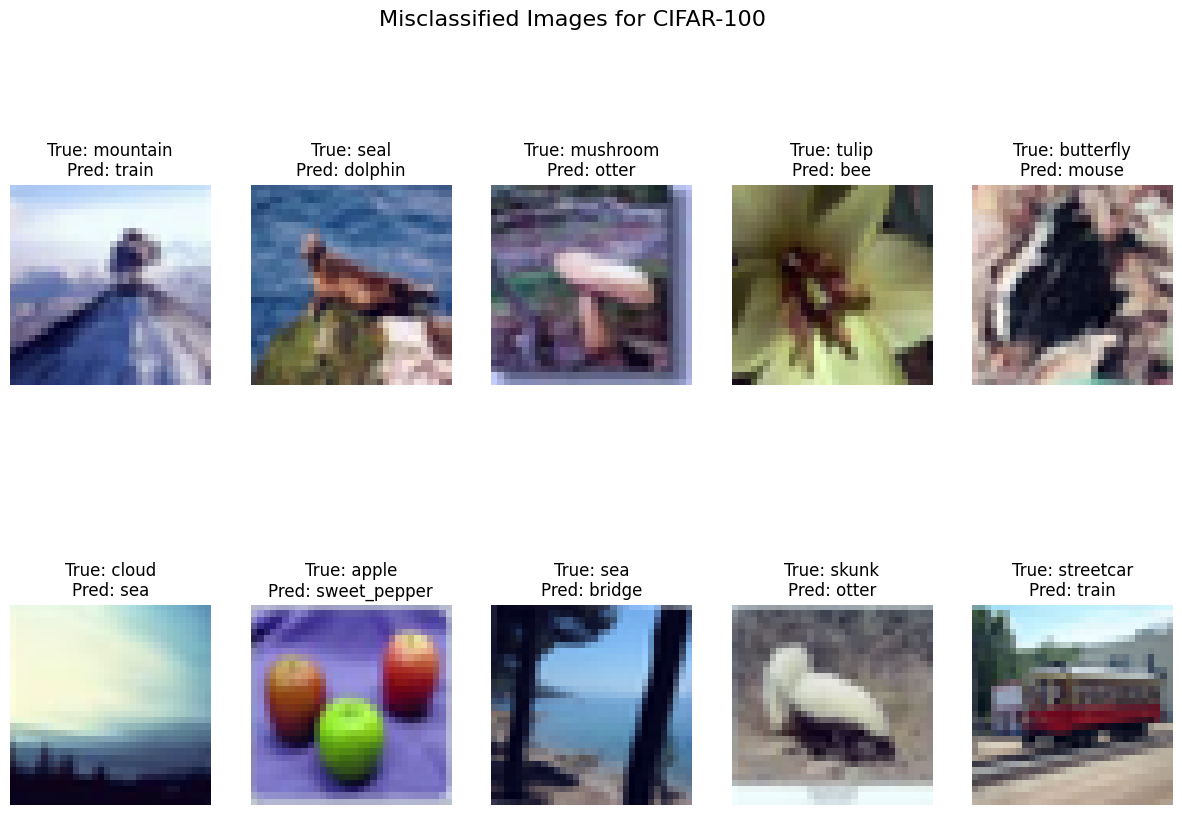

In [ ]:
def analyze_misclassified(model, test_loader, data='CIFAR-10'):
    model.eval()
    misclassified_images = []
    misclassified_true = []
    misclassified_pred = []

    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            test_outputs = model(test_images)
            _, test_preds = torch.max(test_outputs, 1)

            # Find misclassified images
            misclassified_idx = (test_preds != test_labels).nonzero(as_tuple=True)[0]
            for idx in misclassified_idx:
                misclassified_images.append(test_images[idx].cpu())
                misclassified_true.append(test_labels[idx].item())
                misclassified_pred.append(test_preds[idx].item())

    # Visualize misclassified images
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'Misclassified Images for {data}', fontsize=16)
    for i in range(min(10, len(misclassified_images))):  # Show first 10 misclassified images
        plt.subplot(2, 5, i + 1)
        img = misclassified_images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
        plt.imshow(img)
        plt.title(f"True: {test_loader.dataset.classes[misclassified_true[i]]}\nPred: {test_loader.dataset.classes[misclassified_pred[i]]}")
        plt.axis('off')
    plt.show()

# Analyze misclassified images for CIFAR-10
analyze_misclassified(model, test_loader)

# Analyze misclassified images for CIFAR-100
analyze_misclassified(model_100, test_100, data='CIFAR-100')

Analyzing the misclassified images reveals several patterns that help explain why the CNN struggled with certain predictions. Since CIFAR-10 and CIFAR-100 images are only 32x32 pixels, the resolution is extremely low, making it difficult for the network to capture fine-grained details. Many images appear blurry or lack clear distinguishing features, which makes classification challenging even for humans. As a result, the CNN may struggle with visually complex or similar-looking objects, leading to systematic errors. In many cases, misclassification occurs because the model overgeneralizes certain features, fails to differentiate between objects with similar shapes or colors, or relies too heavily on contextual cues rather than distinct object characteristics.

For CIFAR-10, many errors suggest that the model struggles with separating objects that share broad visual similarities. The misclassification of an airplane as a ship, for example, likely stems from the elongated shape and the presence of blue backgrounds, which may have led the model to associate the image with water. A deer being mistaken for a ship might have occurred for a similar reason—the CNN could have misinterpreted the background as an indicator of the object’s identity, rather than focusing on the features of the deer itself. Likewise, several quadrupeds, such as dogs and frogs, were classified as deer, suggesting that the model had difficulty distinguishing animals with similar body structures when texture and finer details were not clearly visible. Some mistakes also indicate that the CNN relied on superficial similarities. A bird being classified as a cat or a cat as a dog suggests that the network may not have fully learned to differentiate between key features like beak shapes or fur patterns. One particularly interesting misclassification was an airplane being predicted as a horse, which might indicate that the model is overly sensitive to certain shapes, potentially mistaking an airplane’s wings for the silhouette of a horse.

The challenges become even more apparent in CIFAR-100, where the model is required to differentiate between a much larger number of classes, many of which share overlapping visual characteristics. For instance, a seal was misclassified as a dolphin, which is understandable given their similar body shapes and aquatic environments. Similarly, a butterfly was mistaken for a mouse, likely because the model failed to correctly interpret certain patterns or textures, mistaking the wing markings for fur or vice versa. Some errors suggest that the model is associating objects with their typical environments rather than focusing on their distinct features. For example, an image of the sea was misclassified as a bridge, possibly because bodies of water frequently co-occur with bridges in the dataset, leading the model to form an incorrect association. Other errors highlight the difficulty of distinguishing between objects with similar overall shapes, such as a mushroom being classified as an otter or an apple being mistaken for a sweet pepper. The classification of a tulip as a bee suggests that the CNN may have relied too much on global textures rather than recognizing localized, discriminative features, possibly confusing dark areas in the flower’s center with the shape of an insect.

These patterns suggest that the model’s misclassifications stem from multiple factors, including the low resolution of CIFAR images, over-reliance on background context, difficulty distinguishing visually similar objects, and potential overfitting to specific shape patterns. Addressing these issues could involve the following strategies:
1. Data level strategy: At the data level, the primary focus is on enhancing the quality and diversity of the training data. One of the most significant limitations of the CIFAR datasets is their low resolution (32x32 pixels), which makes it difficult for the model to extract fine-grained details. Increasing the image resolution can provide more texture, shape details, and small distinguishing features, making it easier for the model to differentiate between visually similar classes. This is particularly important for CIFAR-100, where fine-grained distinctions are critical. While higher-resolution datasets may require more computational resources, they can significantly improve the model's performance. 
    
    In addition to increasing resolution, optimizing data augmentation techniques can further enhance the model's robustness. While a data augmentation pipeline has already been implemented, more rigorous testing and advanced techniques can be explored. For instance, cutout, which randomly erases parts of the image, forces the model to focus on different regions, reducing over-reliance on specific features. Similarly, mixup, which combines two images and their labels, encourages the model to learn more robust and generalizable features. 
2. Model level strategy: At the model level, the focus shifts to using more sophisticated architectures and techniques to improve feature extraction and representation learning. Attention-based models, for example, incorporate mechanisms like self-attention or squeeze-and-excitation blocks to help the model focus on important regions of the image, reducing reliance on misleading background elements. This is particularly useful for distinguishing between classes with overlapping global features but distinct local details, such as tulips and bees or butterflies and mice.
    
    Another approach is to use feature pyramid networks (FPNs), which combine features from different layers to capture multi-scale information. This enables the model to detect both global and local details, improving its ability to distinguish between visually similar classes. Additionally, vision transformers (ViTs), which leverage transformer-based architectures, can capture long-range dependencies and fine-grained features, further enhancing the model's performance.

    Ensemble learning is another powerful strategy, where predictions from multiple models are combined to improve overall accuracy and robustness. Techniques like model averaging or stacking can reduce the likelihood of misclassification by leveraging the strengths of multiple models. This approach is particularly effective for challenging classes, as it improves generalization and robustness.
3. Training level strategy: At the training level, the focus is on optimizing the learning process to improve the model's generalization and robustness. While learning rate scheduling and regularization have already been implemented, further optimization and additional techniques can be explored. For instance, advanced learning rate schedules like cyclic learning rates or one-cycle learning can dynamically adjust the learning rate during training, improving convergence and performance.

    Adversarial training is another technique that can enhance the model's robustness. By introducing adversarial examples during training, the model becomes more resilient to small perturbations and noisy inputs. Similarly, contrastive learning can be used to train the model to differentiate between similar-looking objects by maximizing the similarity between positive pairs (e.g., different views of the same image) and minimizing the similarity between negative pairs (e.g., images of different classes). This encourages the model to focus on critical features rather than general shape or texture alone.

    Proper hyperparameter tuning is also essential to ensure that the model is trained with the best possible set of hyperparameters. Techniques like grid search, random search, or Bayesian optimization can systematically explore different combinations of hyperparameters, maximizing performance and reducing misclassification.

### **Feature map visualisation**

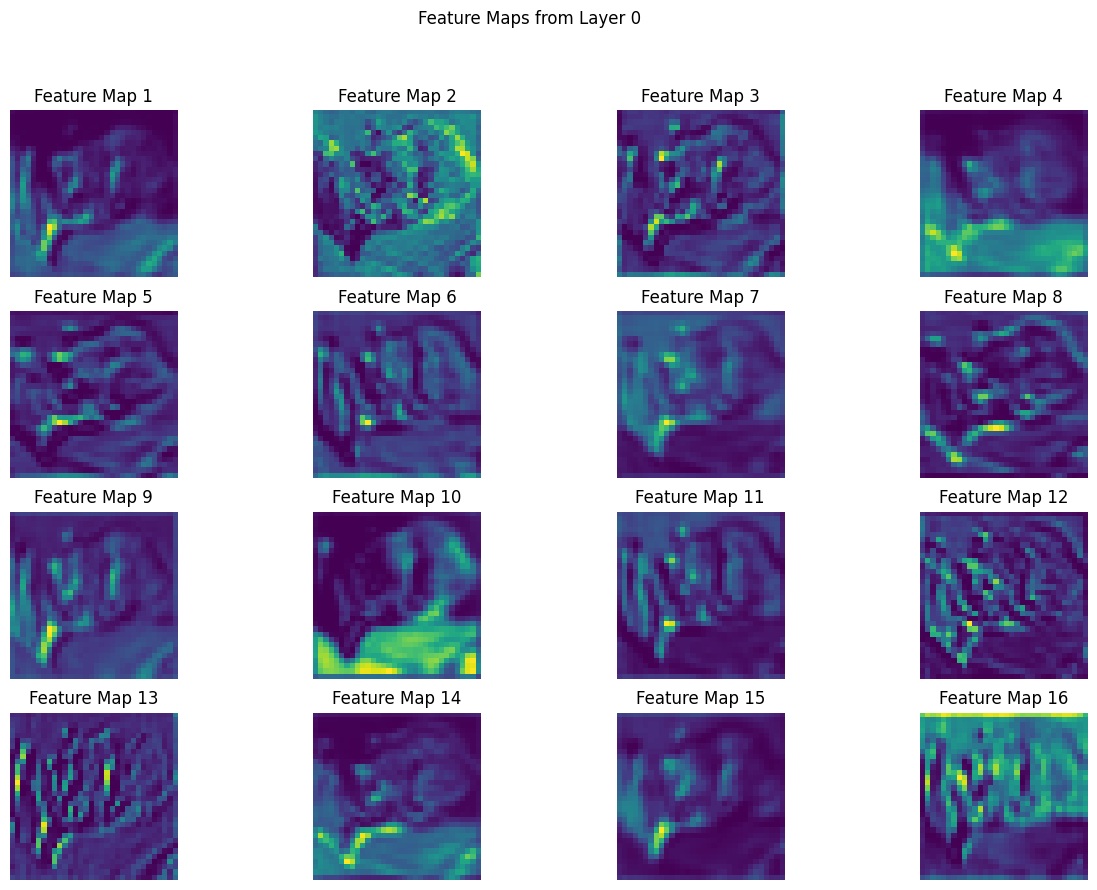

In [ ]:
def visualize_feature_maps(model, test_image, layer_index):
    """
    Visualize feature maps from a specific convolutional layer.
    """
    model.eval()

    # Register a hook to capture the feature maps
    feature_maps = []
    def hook_fn(module, input, output):
        feature_maps.append(output)

    # Attach the hook to the specified layer
    layer = list(model.children())[layer_index]
    hook = layer.register_forward_hook(hook_fn)

    # Forward pass
    with torch.no_grad():
        model(test_image.unsqueeze(0).to(device))

    # Remove the hook
    hook.remove()

    # Visualize feature maps
    feature_maps = feature_maps[0].squeeze().cpu().numpy()
    num_feature_maps = feature_maps.shape[0]

    plt.figure(figsize=(15, 10))
    for i in range(min(16, num_feature_maps)):  # Show first 16 feature maps
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.title(f"Feature Map {i + 1}")
        plt.axis('off')
    plt.suptitle(f"Feature Maps from Layer {layer_index}")
    plt.show()

# Example usage
test_image, _ = next(iter(test_loader))  # Get a test image
test_image = test_image[0]  # Select the first image in the batch
visualize_feature_maps(model, test_image, layer_index=0)  # Visualize feature maps from the first convolutional layer

These visualisations offer a glimpse into the initial stages of feature extractions and reveal the fundamental patterns and structures that the network has learnt. As seen above, each of the 16 feature maps displays a distinct activation pattern, indicating that each filter within Layer 0 is responding to a unique set of features.  A notable observation is the prevalence of edge-like structures across several feature maps. For instance, feature Maps 1, 9, 13, and 16 seem to highlight linear boundaries and sharp transitions, suggesting that the network is likely sensitive to the presence of edges in the input images, consistent with the understanding of early convolutional layers, which typically learn to detect basic geometric features.

It is also observed that simple texture patterns or localised activations are present in some of the feature maps.  While these patterns are less distinct than the edge features, they indicate that the network is also beginning to capture variations in surface textures and small, localised regions of interest.  The diversity of these activation patterns across the 16 feature maps underscores the network's ability to learn a variety of basic features, effectively decomposing the input images into their constituent components. 

However, it is also important to acknowledge that these features are highly abstract and low-level.  They do not represent complete objects or semantic concepts, but rather the fundamental building blocks that subsequent layers will use to construct more complex representations. These features observed in Layer 0 provide the foundation for the network to detect higher-level features, such as object parts and ultimately, entire objects, in deeper layers.

### **Grad-CAM visualisations**

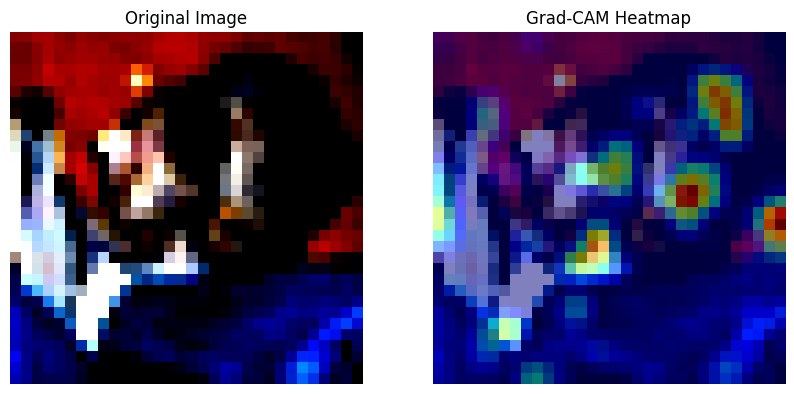

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        """
        Args:
            model: Trained model.
            target_layer: Target convolutional layer for Grad-CAM.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_image, target_class=None):
        """
        Generate Grad-CAM heatmap for the input image.
        """
        # Ensure the model is in evaluation mode
        self.model.eval()

        # Forward pass
        output = self.model(input_image.unsqueeze(0).to(device))

        # If target_class is not provided, use the predicted class
        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()

        # Backward pass
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output)

        # Compute Grad-CAM
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)  # Apply ReLU to highlight positive influences
        cam = F.interpolate(cam, size=input_image.shape[1:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().detach().cpu().numpy()

        # Normalize the heatmap
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

# Get the target layer
target_layer = list(model.children())[-4]  # Adjust based on model architecture

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Generate Grad-CAM heatmap
cam = grad_cam.generate_cam(test_image)

# Visualize the heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image.permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_image.permute(1, 2, 0).cpu().numpy())
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.show()

In the above, warmer colours (red, orange, yellow) on the right image indicate regions with higher importance ie the network focused on these areas when making its classification. Cooler colours indicate regions with lower importance ie network paid less attention to these areas. Due to the low resolution of the input image, it is challenging to precisely identify the specific features that the network is focusing on. However, the heatmap clearly shows that the CNN is not processing the image uniformly. Instead, it is attending to specific areas that it deems relevant for classification. This confirms that the CNN is focusing on specific features within the image, even at low resolution.  While the exact nature of these features is somewhat ambiguous due to the image's limited detail, the heatmap demonstrates the network's ability to selectively attend to relevant image regions.

### **Prediction**

True Label: cat
Predicted Class: cat, Confidence: 86.63%


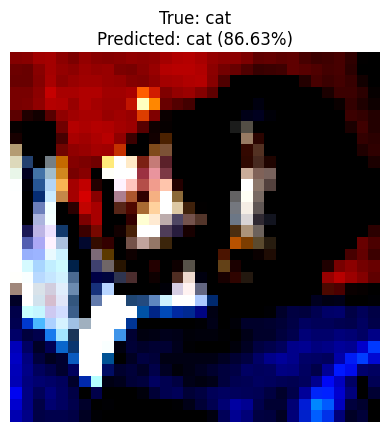

In [ ]:
def predict(model, image, class_names):
    """
    Perform a prediction on a single input image.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Move the image to the same device as the model
    image = image.to(device)

    # Add a batch dimension and perform a forward pass
    with torch.no_grad():
        output = model(image.unsqueeze(0))

    # Apply softmax to convert logits to probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)

    # Get the predicted class and confidence score
    confidence, predicted_idx = torch.max(probabilities, dim=1)
    predicted_class = class_names[predicted_idx.item()]
    confidence = confidence.item()

    return predicted_class, confidence

# Get a test image
test_image, true_label = next(iter(test_loader))  # Get a batch of test images
test_image = test_image[0]  # Select the first image in the batch
true_label = true_label[0].item()  # Get the true label for the image

# Define class names (for CIFAR-10)
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Perform prediction
predicted_class, confidence = predict(model, test_image, class_names)

# Print results
print(f"True Label: {class_names[true_label]}")
print(f"Predicted Class: {predicted_class}, Confidence: {confidence * 100:.2f}%")

# Visualize the image and prediction
plt.imshow(test_image.permute(1, 2, 0).cpu().numpy())
plt.title(f"True: {class_names[true_label]}\nPredicted: {predicted_class} ({confidence * 100:.2f}%)")
plt.axis('off')
plt.show()

It is fascinating to see that the image actually belonged to a cat, because with the naked eye, it is impossible to discern any clear features of a cat. This revelation highlights the stark difference between human and machine perception -- CNN in its own did find meaningful patterns within the image that led to the correct classification. The heatmap's highlighted regions, which appear to be somewhat abstract blobs and color variations, evidently contained discriminative information that the network recognised as indicative of a cat.

### **Experimentation section**
In this section, select experimentations on the data augmentation, architecture and training pipeline are presented and discussed.

#### **Experiment 1: Introduction of Residual Connection & Refinement to training loop**
The major change in this architecture code is the addition of *shortcut connections (residual connections)* within each layer block. In the previous implementation, the layers were sequential, meaning that the output of one layer was directly passed as input to the next without any identity mapping. Here, if the input and output channel dimensions do not match, or if the stride changes, a shortcut path is created using a 1x1 convolution and batch normalization. This is inspired by the ResNet architecture, where shortcut connections help alleviate vanishing gradients and allow deeper networks to learn effectively.  Instead of forcing the model to learn a completely new representation at each layer, these connections retain parts of the original input, helping the model maintain crucial features. Theoretically, the classifier should receive better-refined feature maps due to the residual connections.

In [ ]:
class CNN2(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN2, self).__init__()

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU()
        )

        # Residual stages
        self.layer1, self.shortcut1 = self._make_layer(64, 128, stride=1)
        self.layer2, self.shortcut2 = self._make_layer(128, 256, stride=2)
        self.layer3, self.shortcut3 = self._make_layer(256, 512, stride=2)

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ]

        # Shortcut connection
        shortcut = None
        if in_channels != out_channels or stride != 1:
            shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        return nn.Sequential(*layers), shortcut

    def forward(self, x):
        x = self.stem(x)

        # Layer 1
        identity = x
        x = self.layer1(x)
        if self.shortcut1 is not None:
            identity = self.shortcut1(identity)
        x += identity
        x = nn.GELU()(x)

        # Layer 2
        identity = x
        x = self.layer2(x)
        if self.shortcut2 is not None:
            identity = self.shortcut2(identity)
        x += identity
        x = nn.GELU()(x)

        # Layer 3
        identity = x
        x = self.layer3(x)
        if self.shortcut3 is not None:
            identity = self.shortcut3(identity)
        x += identity
        x = nn.GELU()(x)

        # Classifier
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

**Refined training loop**
1. Patience increased from 5 to 7: A higher patience value allows the model to train longer, giving it a chance to escape any temporary plateaus in validation accuracy. Sometimes, training may encounter periods of slow improvement, but with a high patience value, the model has more time to "recover" and potentially improve.
2. Delta decreased from 0.001 to 0.0005: A smaller delta means a smaller improvement in validation accuracy is needed before considering it as a meaningful progress. This allows the model to react to even small improvements and prevent it from stopping too early based on trivial changes. If the model is overfitting to noisy data, this ensures that the model does not halt too early when validation accuracy temporarily dips, as long as there is consistent progress overall.
3. Epochs increased from 20 to 30: A larger number of epochs gives the model more time to converge towards an optimal solution. From the loss and accuracy curves in the first model, it seemed like there was still room for potential improvement in model performance. Thus, an increment was made here.

In [ ]:
class EarlyStopping2:
    def __init__(self, patience=7, min_delta=0.0005, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_accuracy = 0.0 
        self.counter = 0
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_acc):
        if val_acc > self.best_val_accuracy + self.min_delta:  # Compare with best accuracy
            self.best_val_accuracy = val_acc
            self.counter = 0
            if self.verbose:
                print(f"Validation accuracy improved to {val_acc:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Validation accuracy did not improve. Patience: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered.")

def train2(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, save_path='best_model.pth'):
    model.to(device)
    model.train()
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    early_stopping = EarlyStopping2(patience=7, min_delta=0.0005, verbose=True)

    for epoch in range(epochs):
        model.train()
        running_loss, running_correct, total_samples = 0.0, 0, 0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for image, labels in train_loop:
            image, labels = image.to(device), labels.to(device)  # Move input to device
            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * image.size(0)
            _, pred = torch.max(outputs, 1)
            running_correct += (pred == labels).sum().item()
            total_samples += labels.size(0)

            train_loop.set_postfix(loss=loss.item(), acc=(running_correct / total_samples))

        epoch_loss = running_loss / total_samples
        epoch_acc = running_correct / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for val_images, val_labels in val_loop:
                val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move val data to device
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)

                val_loss += loss.item() * val_images.size(0)
                _, val_pred = torch.max(val_outputs, 1)
                val_correct += (val_pred == val_labels).sum().item()
                val_total += val_labels.size(0)

                val_loop.set_postfix(loss=val_loss / val_total, acc=(val_correct / val_total))

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save model if validation accuracy improves
        if val_acc > early_stopping.best_val_accuracy + early_stopping.min_delta:
            print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
            print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

            torch.save(model.state_dict(), save_path)
            print(f'New best model saved with validation accuracy: {val_acc:.4f}')

        # Early stopping
        early_stopping(val_acc)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

# Initialize the model for CIFAR-10
model_10 = CNN2(num_classes=10).to(device)  # Move model to the GPU

# Loss function with label smoothing for regularization
criterion_v2 = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: SGD with Nesterov momentum and weight decay
optimizer_v2 = optim.SGD(model_10.parameters(), lr=0.2, momentum=0.9, weight_decay=4e-4, nesterov=True)

# Warmup scheduler: Gradually increase learning rate in early epochs
def warmup_lr_scheduler(optimizer, warmup_epochs, base_lr):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        return 1.0
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

epochs = 30  # Increased for better convergence

scheduler_v2 = torch.optim.lr_scheduler.SequentialLR(
    optimizer_v2,
    schedulers=[
        warmup_lr_scheduler(optimizer_v2, warmup_epochs=5, base_lr=0.2),  # Warmup for 5 epochs
        torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_v2, T_max=epochs - 5, eta_min=1e-6)  # Lower eta_min
    ],
    milestones=[5]
)

# Train the model
train_losses_v2, train_accuracies_v2, val_losses_v2, val_accuracies_v2 = train2(
    model_10, train_loader, val_loader, criterion_v2, optimizer_v2, scheduler_v2, epochs=epochs, save_path='cifar10_modelv3.pth'
)

Epoch 1/30 [Train]:   1%|          | 3/312 [00:00<00:56,  5.49it/s, acc=0.197, loss=2.56]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1, Train Loss: 1.7884, Train Acc: 0.4315
Validation Loss: 1.8681, Validation Acc: 0.4613
New best model saved with validation accuracy: 0.4613
Validation accuracy improved to 0.4613


Epoch 2, Train Loss: 1.4597, Train Acc: 0.5865
Validation Loss: 1.2953, Validation Acc: 0.6475
New best model saved with validation accuracy: 0.6475
Validation accuracy improved to 0.6475


Epoch 3, Train Loss: 1.2762, Train Acc: 0.6668
Validation Loss: 1.1452, Validation Acc: 0.7244
New best model saved with validation accuracy: 0.7244
Validation accuracy improved to 0.7244


Epoch 4, Train Loss: 1.1340, Train Acc: 0.7324
Validation Loss: 1.1005, Validation Acc: 0.7425
New best model saved with validation accuracy: 0.7425
Validation accuracy improved to 0.7425


Validation accuracy did not improve. Patience: 1/7


Epoch 6, Train Loss: 0.9775, Train Acc: 0.8075
Validation Loss: 1.0290, Validation Acc: 0.7773
New best model saved with validation accuracy: 0.7773
Validation accuracy improved to 0.7773


Epoch 7, Train Loss: 0.9232, Train Acc: 0.8325
Validation Loss: 0.9467, Validation Acc: 0.8143
New best model saved with validation accuracy: 0.8143
Validation accuracy improved to 0.8143


Validation accuracy did not improve. Patience: 1/7


Validation accuracy did not improve. Patience: 2/7


Validation accuracy did not improve. Patience: 3/7


Epoch 11, Train Loss: 0.7717, Train Acc: 0.9007
Validation Loss: 0.9066, Validation Acc: 0.8329
New best model saved with validation accuracy: 0.8329
Validation accuracy improved to 0.8329


Epoch 12, Train Loss: 0.7388, Train Acc: 0.9165
Validation Loss: 0.8850, Validation Acc: 0.8406
New best model saved with validation accuracy: 0.8406
Validation accuracy improved to 0.8406


Validation accuracy did not improve. Patience: 1/7


Validation accuracy did not improve. Patience: 2/7


Validation accuracy did not improve. Patience: 3/7


Validation accuracy did not improve. Patience: 4/7


Validation accuracy did not improve. Patience: 5/7


Validation accuracy did not improve. Patience: 6/7


Validation accuracy did not improve. Patience: 7/7
Early stopping triggered.
Early stopping triggered at epoch 19


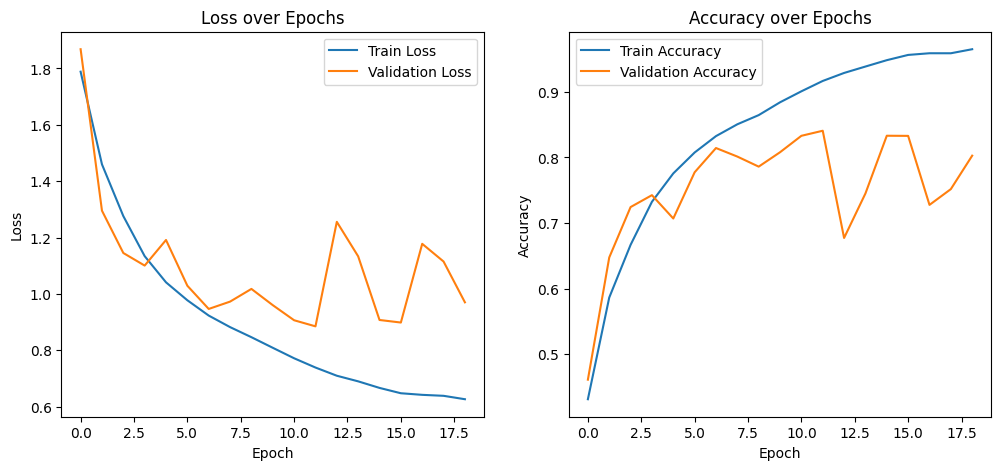

In [ ]:
plot_progress(train_losses_v2, val_losses_v2, train_accuracies_v2, val_accuracies_v2)

Simple test function was executed to compare the performance with the main model presented above.

In [ ]:
def test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct, test_total = 0, 0

    with torch.no_grad():  # Disable gradient computation
        for test_images, test_labels in test_loader:
            # Move data to the same device as the model
            test_images, test_labels = test_images.to(device), test_labels.to(device)

            # Forward pass
            test_outputs = model(test_images)

            # Calculate loss
            loss = criterion(test_outputs, test_labels)
            test_loss += loss.item() * test_images.size(0)

            # Calculate accuracy
            _, test_preds = torch.max(test_outputs, 1)
            test_correct += (test_preds == test_labels).sum().item()
            test_total += test_labels.size(0)

    # Calculate average loss and accuracy
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total

    # Print results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.4f}%")

    return test_loss, test_acc

test_loss, test_acc = test(model_10, test_loader, criterion_v2)

Test Loss: 0.9752, Test Accuracy: 79.9880%


**Transfer learning on CIFAR-100**

Epoch 1/20 [Train]:   0%|          | 1/312 [00:00<00:52,  5.96it/s, acc=0, loss=4.78]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1, Train Loss: 3.6983, Train Acc: 0.1814
Validation Loss: 3.0906, Validation Acc: 0.3287
New best model saved with validation accuracy: 0.3287
Validation accuracy improved to 0.3287


Epoch 2, Train Loss: 2.9628, Train Acc: 0.3507
Validation Loss: 2.7707, Validation Acc: 0.4031
New best model saved with validation accuracy: 0.4031
Validation accuracy improved to 0.4031


Epoch 3, Train Loss: 2.7016, Train Acc: 0.4249
Validation Loss: 2.6051, Validation Acc: 0.4509
New best model saved with validation accuracy: 0.4509
Validation accuracy improved to 0.4509


Epoch 4, Train Loss: 2.5401, Train Acc: 0.4720
Validation Loss: 2.4980, Validation Acc: 0.4799
New best model saved with validation accuracy: 0.4799
Validation accuracy improved to 0.4799


Epoch 5, Train Loss: 2.4207, Train Acc: 0.5082
Validation Loss: 2.4180, Validation Acc: 0.5030
New best model saved with validation accuracy: 0.5030
Validation accuracy improved to 0.5030


Epoch 6, Train Loss: 2.3231, Train Acc: 0.5380
Validation Loss: 2.3542, Validation Acc: 0.5223
New best model saved with validation accuracy: 0.5223
Validation accuracy improved to 0.5223


Epoch 7, Train Loss: 2.2419, Train Acc: 0.5642
Validation Loss: 2.3105, Validation Acc: 0.5351
New best model saved with validation accuracy: 0.5351
Validation accuracy improved to 0.5351


Epoch 8, Train Loss: 2.1690, Train Acc: 0.5891
Validation Loss: 2.2717, Validation Acc: 0.5478
New best model saved with validation accuracy: 0.5478
Validation accuracy improved to 0.5478


Epoch 9, Train Loss: 2.1042, Train Acc: 0.6095
Validation Loss: 2.2322, Validation Acc: 0.5569
New best model saved with validation accuracy: 0.5569
Validation accuracy improved to 0.5569


Epoch 10, Train Loss: 2.0454, Train Acc: 0.6297
Validation Loss: 2.2080, Validation Acc: 0.5667
New best model saved with validation accuracy: 0.5667
Validation accuracy improved to 0.5667


Epoch 11, Train Loss: 1.9936, Train Acc: 0.6491
Validation Loss: 2.1779, Validation Acc: 0.5755
New best model saved with validation accuracy: 0.5755
Validation accuracy improved to 0.5755


Epoch 12, Train Loss: 1.9399, Train Acc: 0.6636
Validation Loss: 2.1612, Validation Acc: 0.5815
New best model saved with validation accuracy: 0.5815
Validation accuracy improved to 0.5815


Validation accuracy did not improve. Patience: 1/7


Epoch 14, Train Loss: 1.8426, Train Acc: 0.7036
Validation Loss: 2.1322, Validation Acc: 0.5878
New best model saved with validation accuracy: 0.5878
Validation accuracy improved to 0.5878


Epoch 15, Train Loss: 1.7977, Train Acc: 0.7190
Validation Loss: 2.1234, Validation Acc: 0.5893
New best model saved with validation accuracy: 0.5893
Validation accuracy improved to 0.5893


Epoch 16, Train Loss: 1.7553, Train Acc: 0.7344
Validation Loss: 2.1073, Validation Acc: 0.5974
New best model saved with validation accuracy: 0.5974
Validation accuracy improved to 0.5974


Validation accuracy did not improve. Patience: 1/7


Validation accuracy did not improve. Patience: 2/7


Validation accuracy did not improve. Patience: 3/7


Epoch 20, Train Loss: 1.5859, Train Acc: 0.8038
Validation Loss: 2.0944, Validation Acc: 0.6002
New best model saved with validation accuracy: 0.6002
Validation accuracy improved to 0.6002


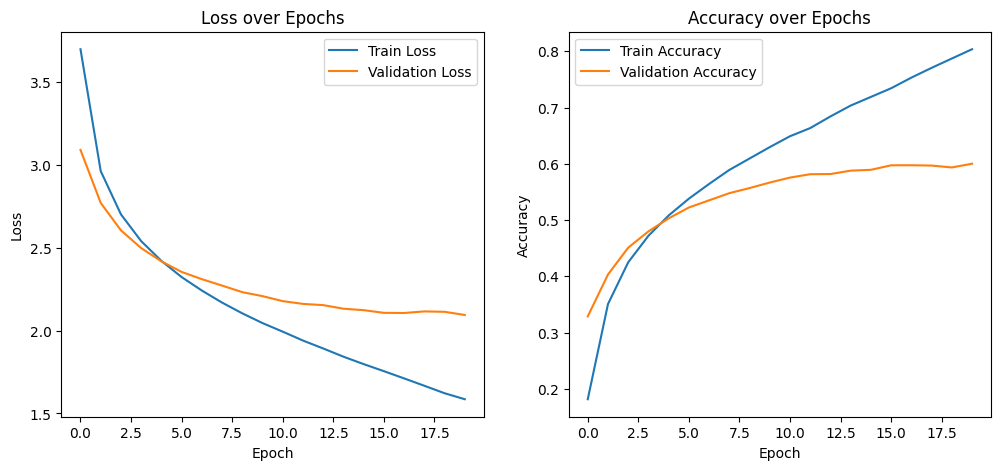

In [ ]:
# Load pre-trained model
model_100v2 = CNN2(num_classes=10).to(device)  # Initialize with 10 classes (CIFAR-10 architecture)
model_100v2.load_state_dict(torch.load('cifar10_modelv3.pth'))  # Load CIFAR-10 weights

# Replace the classifier for CIFAR-100
model_100v2.fc = nn.Sequential(
    nn.LayerNorm(512),
    nn.Dropout(0.3),
    nn.Linear(512, 100)  # 100 classes for CIFAR-100
).to(device)  # Move the new classifier to the correct device

# Unfreeze all layers
for param in model_100v2.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for regularization
optimizer_100v2 = torch.optim.SGD(model_100v2.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, nesterov=True)

# Define the learning rate scheduler
epochs = 20  # Total epochs for fine-tuning
scheduler_100v2 = torch.optim.lr_scheduler.SequentialLR(
    optimizer_100v2,
    schedulers=[
        warmup_lr_scheduler(optimizer_100v2, warmup_epochs=3, base_lr=0.01),  # Warmup for 3 epochs
        torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_100v2, T_max=epochs - 3, eta_min=1e-5)  # Cosine annealing
    ],
    milestones=[3]  # Switch to cosine annealing after warmup
)

# Call the training function
train_losses_100v2, train_accuracies_100v2, val_losses_100v2, val_accuracies_100v2 = train2(
    model_100v2, train_100, val_100, criterion, optimizer_100v2, scheduler_100v2, epochs=20, save_path='cifar100_model.pth'
)

plot_progress(train_losses_100v2, val_losses_100v2, train_accuracies_100v2, val_accuracies_100v2)

In [ ]:
test_loss, test_acc = test(model_100v2, test_loader, criterion_v2)

Test Loss: 6.4998, Test Accuracy: 0.4908%


**Observation:**

It can be seen that in the refined code blocks, with the introduction of residual connections, and small adjustments to certain hyperparameters, the model performed worse on both CIFAR-10 and CIFAR-100. Notably, there were huge fluctuations in validation accuracy on the training process, and overfitting was more pronounced and occurred earlier than it did in the first model presented above. Though the best validation accuracy as well as test accuracy on CIFAR-10 did not differ too significantly from the first model, the test accuracy on CIFAR-100 had a marked reduction. This suggests that the introduction of residual connections and adjustments to hyperparameters may have unintentionally disrupted the model's ability to generalise. Residual networks can sometimes exacerbate overfitting if the model becomes too complex relative to the amount of data available, especially on datasets like CIFAR-10 and CIFAR-100, which can be sensitive to overly complex architectures. The introduction of residual connections may have also increased the model's capacity to memorise, resulting in the overfitting that was observed. In addition, the increment in total number of epochs did not have any impact in this instance as the training terminated after epoch 19. Thus, while these changes were intended to improve the model, further tuning might be needed to carefully balance with the rest of the training configuration to prevent overfitting and instability in validation performance.

#### **Experiment 2: Hyperparameter adjustment to CNN architecture and training parameters**
In this CNN architecture, nn.Identity() is introduced to offer more flexibility with how it handles shortcut connections when the input and output are compatible. Adjustments made are as follows:
1. Increase in out channels across all layers: As identified in the first model, there are difficulties differentiating between classes when the model was applied to CIFAR-100. By increasing the output channels, the model can potentially learn more detailed and diverse features at each layer, improving its ability to handle the increased complexity of CIFAR-100. Besides, the performance on CIFAR-100 using the experimented model was worse than the first model above. Thus, increasing out channels is an attempt to improve model performance.
2. Increase in dropout rate: Considering that the experimented model above was overfitting to training data, increasing dropout rate is intended to make the model more robust and less prone to memorising the training data.

In terms of training, the following changes were also made:
1. Switching to AdamW from SGD: AdamW is typically preferred over SGD for many deep learning tasks due to its adaptive nature. Adam adjusts the learning rates of individual parameters based on their gradients, making it more efficient and effective for tasks that involve sparse data or noisy gradients, which is common in computer vision tasks like training on CIFAR-100. Learning rate was also changed to 2e-4 from the original 3e-4, primarily to help the model converge more smoothly and avoid large updates that could destabilise training when applied to CIFAR-100.
2. Switching to Cosine Annealing LR Scheduler from Warmup with Cosine Annealing: With the change in optimiser to AdamW, its the adaptive nature removes the need for a separate warmup. Thus, Cosine Annealing alone is often sufficient to gradually reduce the learning rate. 

Epoch 1, Train Loss: 1.7622, Train Acc: 0.3889
Validation Loss: 1.5811, Validation Acc: 0.4617
New best model saved with validation accuracy: 0.4617
Validation accuracy improved to 0.4617


Epoch 2, Train Loss: 1.4377, Train Acc: 0.5271
Validation Loss: 1.2862, Validation Acc: 0.5898
New best model saved with validation accuracy: 0.5898
Validation accuracy improved to 0.5898


Epoch 3, Train Loss: 1.2645, Train Acc: 0.6003
Validation Loss: 1.1983, Validation Acc: 0.6271
New best model saved with validation accuracy: 0.6271
Validation accuracy improved to 0.6271


Epoch 4, Train Loss: 1.1658, Train Acc: 0.6459
Validation Loss: 1.1622, Validation Acc: 0.6442
New best model saved with validation accuracy: 0.6442
Validation accuracy improved to 0.6442


Validation accuracy did not improve. Patience: 1/5


Epoch 6, Train Loss: 1.0226, Train Acc: 0.7080
Validation Loss: 1.0476, Validation Acc: 0.7006
New best model saved with validation accuracy: 0.7006
Validation accuracy improved to 0.7006


Epoch 7, Train Loss: 0.9659, Train Acc: 0.7346
Validation Loss: 0.9602, Validation Acc: 0.7377
New best model saved with validation accuracy: 0.7377
Validation accuracy improved to 0.7377


Epoch 8, Train Loss: 0.9076, Train Acc: 0.7590
Validation Loss: 0.9263, Validation Acc: 0.7469
New best model saved with validation accuracy: 0.7469
Validation accuracy improved to 0.7469


Epoch 9, Train Loss: 0.8595, Train Acc: 0.7796
Validation Loss: 0.9131, Validation Acc: 0.7551
New best model saved with validation accuracy: 0.7551
Validation accuracy improved to 0.7551


Validation accuracy did not improve. Patience: 1/5


Validation accuracy did not improve. Patience: 2/5


Epoch 12, Train Loss: 0.7339, Train Acc: 0.8322
Validation Loss: 0.8411, Validation Acc: 0.7825
New best model saved with validation accuracy: 0.7825
Validation accuracy improved to 0.7825


Epoch 13, Train Loss: 0.7035, Train Acc: 0.8455
Validation Loss: 0.7823, Validation Acc: 0.8103
New best model saved with validation accuracy: 0.8103
Validation accuracy improved to 0.8103


Validation accuracy did not improve. Patience: 1/5


Validation accuracy did not improve. Patience: 2/5


Validation accuracy did not improve. Patience: 3/5


Validation accuracy did not improve. Patience: 4/5


Epoch 18, Train Loss: 0.5329, Train Acc: 0.9207
Validation Loss: 0.8075, Validation Acc: 0.8117
New best model saved with validation accuracy: 0.8117
Validation accuracy improved to 0.8117


Epoch 19, Train Loss: 0.4988, Train Acc: 0.9369
Validation Loss: 0.7732, Validation Acc: 0.8217
New best model saved with validation accuracy: 0.8217
Validation accuracy improved to 0.8217


Validation accuracy did not improve. Patience: 1/5


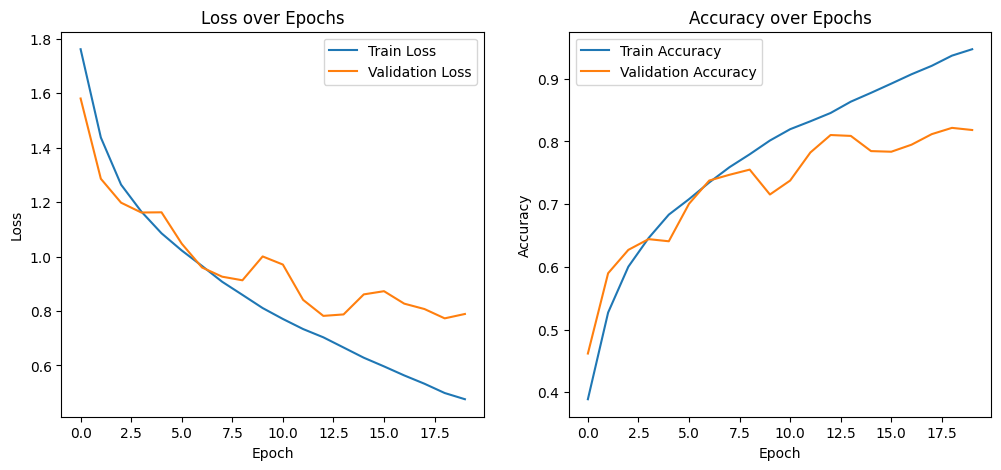

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10): 
        super(CNN, self).__init__()

        # Initial stem layer
        self.stem = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU()
        )

        # Residual convolutional layers
        self.layer1, self.skip1 = self._make_layer(128, 256, stride=1)
        self.layer2, self.skip2 = self._make_layer(256, 512, stride=2)
        self.layer3, self.skip3 = self._make_layer(512, 768, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.LayerNorm(768),
            nn.Dropout(0.4),
            nn.Linear(768, num_classes)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        """Creates a residual block with a proper skip connection."""
        layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Define skip connection separately
        skip_connection = (
            nn.Identity() if in_channels == out_channels and stride == 1
            else nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        )

        return layers, skip_connection

    def forward(self, x):
        x = self.stem(x)

        # Apply residual connections correctly
        residual = x
        x = self.layer1(residual) + self.skip1(residual)  # Residual connection

        residual = x
        x = self.layer2(residual) + self.skip2(residual)  # Residual connection

        residual = x
        x = self.layer3(residual) + self.skip3(residual)  # Residual connection

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # Reduced label smoothing
epochs = 20

# Optimizer: Switch to AdamW for better generalization
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)  # AdamW with lower weight decay. reduce to lr 2e-4 for cifar100

# Learning Rate Scheduler: Simple Cosine Annealing
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=epochs, save_path='cifar10_modeltrial.pth'
)

# Plot training progress
plot_progress(train_losses, val_losses, train_accuracies, val_accuracies)

With the above changes implemented in this experimentation, the training process is more stable than the model developed in experiment 1. However, overfitting is still observed, and the performance is not as good as in the first model. Transfer learning and testing will not be attempted.

#### **Experiment 3: Data Augmentation Pipeline adjustment**
Aside from just architecture experimentation, some minor adjustments were also made to the data augmentation pipeline to compare any potential improvements in performance.

1. Reduced padding from 4 to 2: This ensures that the random crop focuses more on the central, relevant areas of the image, rather than including a lot of irrelevant background or extra space. This helps the model focus on learning the key features of the object in the image. 
2. Reduced scale & ratio of random erasing: Encourages the model to become more robust to missing or occluded information, without removing too much of the image. Also ensures that the model is not forced to learn from distorted or incomplete data, but still learns to generalise from partially obscured images.

In [ ]:
def load_dataset(dataset_name, mean, std):
    # Define transformation pipeline for training (with augmentations)
    train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=2),  # Random crop with reduced padding
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    AutoAugment(AutoAugmentPolicy.CIFAR10),  # Use CIFAR-10 specific policy
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean.tolist(), std.tolist()),  # Normalize
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 0.5), value=0)  # Random erasing with smaller scale and ratio
])

    # Define transformation pipeline for validation/test (no augmentations)
    val_test_transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean.tolist(), std.tolist()),  # Normalize
    ])

    # Load datasets with appropriate transformations
    if dataset_name == 'CIFAR10':
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
    elif dataset_name == 'CIFAR100':
        train_dataset = datasets.CIFAR100(root='./data', train=True, download=True)
        test_dataset = datasets.CIFAR100(root='./data', train=False, download=True)
    else:
        raise ValueError("Dataset name must be either 'CIFAR10' or 'CIFAR100'")

    # Split training set into train and validation subsets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size

    # Split indices into training and validation
    train_indices, val_indices = random_split(range(len(train_dataset)), [train_size, val_size])

    # Create subsets of training and validation sets to decouple the transformation
    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    val_subset = torch.utils.data.Subset(train_dataset, val_indices)

    # Apply transformations to the subsets
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_test_transform
    test_dataset.transform = val_test_transform

    # Create dataloaders
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2, drop_last=True, persistent_workers=True)
    val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2, drop_last=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, drop_last=True, persistent_workers=True)

    return train_loader, val_loader, test_loader

# Load CIFAR-10 dataset
train_loader, val_loader, test_loader = load_dataset('CIFAR10', mean_10, std_10)

# Load CIFAR-100 dataset
train_100, val_100, test_100 = load_dataset('CIFAR100', mean_100, std_100)

#### **Experiment 3: Architecture & training adjustment**
In this experimentation block, several other advanced techniques were implemented in an attempt to improve feature learning (via SEBlocks) and generalisation (via stochastic depth and dropout). It uses modern techniques like residual connections, SE blocks, and stochastic depth to create a more powerful and robust network.
1. Squeeze-and-Excitation Block: The SEBlock is designed to capture channel-wise dependencies. It uses global average pooling to condense spatial information into a channel descriptor, then learns channel-wise attention via two fully connected layers. This attention mechanism allows the network to recalibrate channel importance. 
2. StochasticDepth: This technique introduces stochastic depth, randomly "dropping" entire residual paths during training, forcing the model to learn to rely on multiple paths. This prevents overfitting by making the network more robust and encouraging better generalisation. During training, the output is scaled by 1 / (1 - drop_prob) to maintain the expected output, preventing the model from receiving fewer activations when certain paths are dropped. 
3. SiLU activation function: The original activation, GELU, has been replaced with SiLU (Swish) as it often performs well due to its smooth, non-monotonic behavior and has been shown to work better in certain deep networks, leading to faster convergence and potentially better performance.

In the training loop, 
1. A higher lr of 0.001 with AdamW: A learning rate of 3e-4 in the training loop under experiment 2 might be too low for a CNN model trained from scratched. Smaller values are typically used for more fine-tuned models or when the training process has already been optimised with lower rates (might be preferred for CIFAR-100 during tranfer learning than when trained on CIFAR-10). Thus, a higher value will be attempted here.
2. A higher weight decay from 1e-4: It is evident that overfitting occurred in experimentation 3, thus the increment is intended to help the model generalise better by discouraging large weight values and reducing overfitting. 
3. CosineAnnealingWarmRestarts: Considering that overfitting is an occurrence throughout all experimentations, this is an attempt to allow the optimiser to periodically restart the learning rate, encouraging the model to explore the loss surface and reducing the chances of getting stuck in a local minimum.

In [7]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.SiLU(),  # Swish activation instead of GELU
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avgpool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class StochasticDepth(nn.Module):
    """Applies stochastic depth during training to randomly drop residual paths."""
    def __init__(self, drop_prob):
        super(StochasticDepth, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1 - self.drop_prob
        mask = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < keep_prob
        return x * mask / keep_prob  # Scale by keep_prob to maintain expected value

class CNN(nn.Module):
    def __init__(self, num_classes=100, drop_prob=0.2, stochastic_depth_prob=0.1):
        super(CNN, self).__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.SiLU(inplace=True)  # Swish activation
        )

        # Residual convolutional layers with stochastic depth
        self.layer1, self.skip1 = self._make_layer(64, 128, stride=1, drop_prob=stochastic_depth_prob)
        self.layer2, self.skip2 = self._make_layer(128, 256, stride=2, drop_prob=stochastic_depth_prob)
        self.layer3, self.skip3 = self._make_layer(256, 512, stride=2, drop_prob=stochastic_depth_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.LayerNorm(512),
            nn.Dropout(drop_prob),
            nn.Linear(512, num_classes)
        )

    def _make_layer(self, in_channels, out_channels, stride, drop_prob=0.1):
        """Creates a residual block with a proper skip connection and stochastic depth."""
        layers = nn.Sequential(
            nn.BatchNorm2d(in_channels),  # Pre-activation BN
            nn.SiLU(inplace=True),  # Swish activation
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels // 4),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels // 4),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels // 4, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        skip_connection = (
            nn.Identity() if in_channels == out_channels and stride == 1
            else nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        )

        se_block = SEBlock(out_channels)
        return nn.Sequential(layers, se_block, StochasticDepth(drop_prob)), skip_connection

    def forward(self, x):
        x = self.stem(x)

        residual = x
        x = self.layer1(residual) + self.skip1(residual)

        residual = x
        x = self.layer2(residual) + self.skip2(residual)

        residual = x
        x = self.layer3(residual) + self.skip3(residual)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0005, verbose=True, save_path='best_model.pth', restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_accuracy = 0.0
        self.counter = 0
        self.early_stop = False
        self.verbose = verbose
        self.save_path = save_path
        self.restore_best_weights = restore_best_weights
        self.best_model_state = None  # Store the best model state

    def __call__(self, val_acc, model):
        if val_acc > self.best_val_accuracy + self.min_delta:
            self.best_val_accuracy = val_acc
            self.counter = 0
            # Save the best model state
            self.best_model_state = model.state_dict()
            torch.save(self.best_model_state, self.save_path)
            if self.verbose:
                print(f"New best model saved with validation accuracy: {val_acc:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Validation accuracy did not improve. Patience: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model_state is not None:
                    model.load_state_dict(self.best_model_state)  # Restore the best model weights
                    print("Restored model weights from the best checkpoint.")
                print("Early stopping triggered.")

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, save_path='best_model.pth'):
    model.to(device)
    model.train()
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    early_stopping = EarlyStopping(patience=7, min_delta=0.0005, verbose=True, save_path=save_path)

    best_val_acc = 0.0  # Track the best validation accuracy

    for epoch in range(epochs):
        model.train()
        running_loss, running_correct, total_samples = 0.0, 0, 0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for image, labels in train_loop:
            image, labels = image.to(device), labels.to(device)  # Move input to device
            optimizer.zero_grad()

            # Forward pass
            outputs = model(image)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            # Update metrics
            running_loss += loss.item() * image.size(0)
            _, pred = torch.max(outputs, 1)
            running_correct += (pred == labels).sum().item()
            total_samples += labels.size(0)

            train_loop.set_postfix(loss=loss.item(), acc=(running_correct / total_samples))

        # Step the scheduler at the end of each epoch
        scheduler.step()

        # Calculate epoch metrics
        epoch_loss = running_loss / total_samples
        epoch_acc = running_correct / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for val_images, val_labels in val_loop:
                val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move val data to device
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)

                val_loss += loss.item() * val_images.size(0)
                _, val_pred = torch.max(val_outputs, 1)
                val_correct += (val_pred == val_labels).sum().item()
                val_total += val_labels.size(0)

                val_loop.set_postfix(loss=val_loss / val_total, acc=(val_correct / val_total))

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Early stopping
        early_stopping(val_acc, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=10).to(device)  # Adjust for CIFAR-10 or CIFAR-100
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2, eta_min=1e-5)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=30, save_path='best_model.pth'
)

New best model saved with validation accuracy: 0.5245


New best model saved with validation accuracy: 0.5834


New best model saved with validation accuracy: 0.6268


New best model saved with validation accuracy: 0.6427


New best model saved with validation accuracy: 0.6748


New best model saved with validation accuracy: 0.6990


New best model saved with validation accuracy: 0.7044


New best model saved with validation accuracy: 0.7276


New best model saved with validation accuracy: 0.7364


New best model saved with validation accuracy: 0.7406


Validation accuracy did not improve. Patience: 1/7


New best model saved with validation accuracy: 0.7543


New best model saved with validation accuracy: 0.7598


New best model saved with validation accuracy: 0.7736


Validation accuracy did not improve. Patience: 1/7


Validation accuracy did not improve. Patience: 2/7


Validation accuracy did not improve. Patience: 3/7


Validation accuracy did not improve. Patience: 4/7


New best model saved with validation accuracy: 0.7743


New best model saved with validation accuracy: 0.7750


Validation accuracy did not improve. Patience: 1/7


Validation accuracy did not improve. Patience: 2/7


Validation accuracy did not improve. Patience: 3/7


Validation accuracy did not improve. Patience: 4/7


Validation accuracy did not improve. Patience: 5/7


Validation accuracy did not improve. Patience: 6/7


Validation accuracy did not improve. Patience: 7/7
Restored model weights from the best checkpoint.
Early stopping triggered.
Early stopping triggered at epoch 27


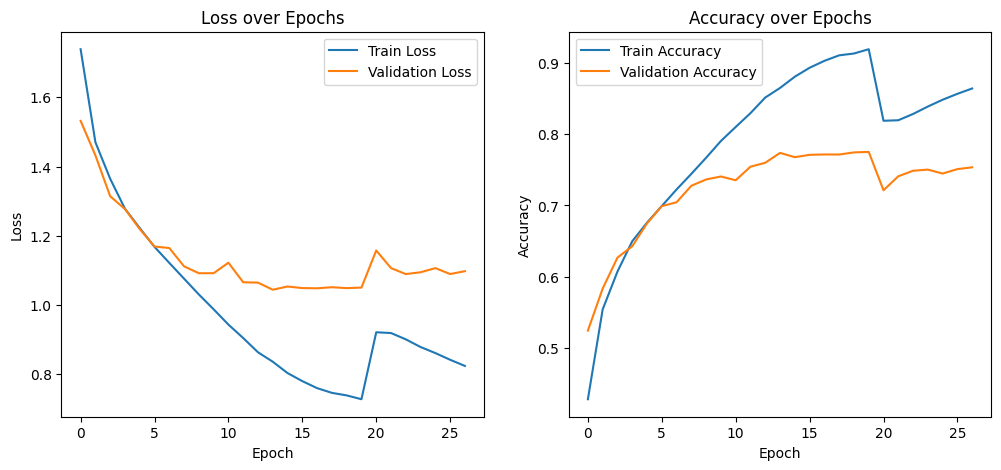

In [8]:
# Plot training and validation loss
def plot_progress(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()

plot_progress(train_losses, val_losses, train_accuracies, val_accuracies)

It seems that the introduceion of CosineAnnealingWarmRestarts was detrimental to the training process. However, it is also notable that the gap between train and validation accuracy became smaller temporarily after the learning rate was adjusted. 